In [1]:
# Initialize a new VAME project
import vame
import functions_bondjango as bd
import functions_vame as fv
import paths
import random
import os
import shutil
import h5py
import numpy as np
import importlib
import pandas as pd

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


In [2]:
# Manually define the config path if project has already been created
# config = r"D:\VAME_projects\VAME_prey_6-Apr28-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_7-Apr29-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May2-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-May14-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_15dim-May17-2021\config.yaml"
# config = r"D:\VAME_projects\VAME_prey_mouse15dim-Oct12-2021\config.yaml"
config = r"D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\config.yaml"

In [2]:
%%time
# get the file paths

# define the number of files to use
number_files = 750
# define the search string
# search_string = ['rig:miniscope, result:succ', 'rig:miniscope, result:fail']
search_string = ['rig:miniscope']
# search_string = ['slug:06_02_2021_09_33_34_miniscope_dg_210323_b_succ_head']

# define the target model
target_model = 'video_experiment'

# define the columns to check for nans
nan_columns = [0, 2, 4, 6, 8, 10, 12, 14]

# allocate memory for the files
files = []

# for all the queries
for query in search_string:
    # get the queryset
    files.append(bd.query_database(target_model, query))

# concatenate the list
files_list = [item for sublist in files for item in sublist]
print(len(files_list))
# allocate memory for the cleaned up files and analysis paths
files = []
analysis_paths = []
# set the columns flag
column_flag = True
# get rid of the files that are too short for pose segmentation
# for all the files
for el in files_list:
    # get the path to the analyzed data file
    dlc_path = el['avi_path']
    dlc_path = dlc_path.replace('.avi', '_rawcoord.hdf5')
    dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
    dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # open the file using h5py, as can't install pytables in this env
    with h5py.File(dlc_path, 'r') as f:
        # parse the bounds from the file
        bounds = np.array(f['frame_bounds/block0_values'])[0]
        # get also the rest of the data to check for nans
        try:
            data = np.array(f['matched_calcium/block0_values'])
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
        column_sum = any(np.sum(np.isnan(data[:, nan_columns]), axis=0)==data.shape[0])
        if column_sum == 1:
            print(f'The file {dlc_path} has only nans in the behavior')
        # if it's the first iteration and a success, get the column names
        if (column_flag) & ('succ' in dlc_path):
            # get the column names
            columns_all = np.array(f['full_traces/block0_items']).astype(str)
            # select the columns with mouse and x or y on them
            column_list = [el for el in columns_all if (('x' in el) or ('y' in el))]
            column_list = [el for el in column_list if 'mouse' in el]
            # set the flag to off
            column_flag = False
#         values = np.array(f['frame_bounds/block0_values'])[0]
#         labels = np.array(f['frame_bounds/block0_items']).astype(str)
#         bounds = pd.DataFrame(values.reshape([1, 3]), columns=labels)
        # add the file to the final list only if it's long enough
#         if (bounds.loc[0, 'end'] - bounds.loc[0, 'start']) > 50:
        if ((bounds[1] - bounds[0]) > 50) & (column_sum == 0):
            files.append(el)
            analysis_paths.append(dlc_path)

if number_files > 0:
    # pick a random subset of number_files
    random_indexes = random.sample(range(len(files)), number_files)
    files = [files[el] for el in random_indexes]
    analysis_paths = [analysis_paths[el] for el in random_indexes]

# get the video paths in a list
video_paths = [el['avi_path'] for el in files]

# define the working directory
working_directory = paths.vame_path
print(len(video_paths))
print(len(analysis_paths))

1239
The file J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\06_02_2021_09_33_34_miniscope_DG_210323_b_succ_head_rawcoord.hdf5 has only nans in the behavior
750
750
Wall time: 49.7 s


In [4]:
%%time

# initialize the project
config = vame.init_new_project(project='VAME_prey_mouse15dim', 
                               videos=video_paths, working_directory=working_directory, videotype='.avi')

Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\videos"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\data"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results"
Created "D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\model"
Copying the videos 

A VAME project has been created. 

Now its time to prepare your data for VAME. The first step is to move your pose .csv file (e.g. DeepLabCut .csv) into the //YOUR//VAME//PROJECT//videos//pose_estimation folder. From here you can call either the function vame.egocentric_alignment() or if your data is by design egocentric call vame.csv_to_numpy(). This will prepare the data in .csv into the right format to start working with VAME.
Wall time: 2min 26s


In [6]:
# # test alignment function
# # define the target example file
# example_file = r"J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\03_29_2021_09_17_07_miniscope_DG_210202_a_succ_preproc.hdf5"

# with h5py.File(example_file, 'r') as f:
#     # parse the bounds from the file
#     try:
#         data = np.array(f['matched_calcium/block0_values'])
#         labels = np.array(f['matched_calcium/block0_items']).astype(str)
#     except KeyError:
#         data = np.array(f['full_traces/block0_values'])
#         labels = np.array(f['full_traces/block0_items']).astype(str)

#     dataframe = pd.DataFrame(data, columns=labels)
# #     filename = el['slug']
#     filename = os.path.splitext(os.path.basename(example_file))[0]
#         # define the cropping
# #     crop_size = (1, 1)
# #     # egocentrically align the data and save
# #     fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)
# # get the egocentrically aligned coordinates
# aligned_traj, frames = vame.egocentric_alignment(config, pose_ref_index=[0, 7], crop_size=(200, 200), 
#                                                  use_video=False, video_format='.avi', 
#                                                  check_video=False, save_flag=False, 
#                                                  filename=[filename], column_list=column_list,
#                                                  dataframe=[dataframe], 
#                                                  extra_columns=['mouse_speed'])

Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3076/3076 [00:10<00:00, 302.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


In [5]:
%%time

# importlib.reload(vame)
# Align video trajectories
# get the project folder
project_folder, _ = os.path.split(config)
# get the columns to use (only mouse in this case)


# for all the videos
for idx, el in enumerate(files):
    print(f'Current file: {el["slug"]}')
    
#     # if there is no preprocessing file, skip and warn
#     if len(el['preproc_files']) == 0:
#         print('no preprocessing file found')
#         continue
#     # load the avi file path
#     dlc_path = el['avi_path']
#     # edit it for the preprocessing path
#     dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
#     dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
#     dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
    # get the path from the list calculated above
    # dlc_path = analysis_paths[idx]
    with h5py.File(analysis_paths[idx], 'r') as f:
        # parse the bounds from the file
        try:
            data = np.array(f['matched_calcium/block0_values'])
            labels = np.array(f['matched_calcium/block0_items']).astype(str)
        except KeyError:
            data = np.array(f['full_traces/block0_values'])
            labels = np.array(f['full_traces/block0_items']).astype(str)
        
        dataframe = pd.DataFrame(data, columns=labels)
        filename = el['slug']
        # define the cropping
#     crop_size = (1, 1)
#     # egocentrically align the data and save
#     fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)
    # get the egocentrically aligned coordinates
    aligned_traj, frames = vame.egocentric_alignment(config, pose_ref_index=[0, 7], crop_size=(200, 200), 
                                                     use_video=False, video_format='.avi', 
                                                     check_video=False, save_flag=True, 
                                                     filename=[filename], column_list=column_list,
                                                     dataframe=[dataframe], 
                                                     extra_columns=['mouse_speed'])

Current file: 08_06_2020_18_24_41_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:02<00:00, 273.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_06_2021_10_05_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 285.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/244 [00:00<?, ?it/s]

Current file: 04_21_2021_15_50_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 272.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/313 [00:00<?, ?it/s]

Current file: 03_06_2020_16_00_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 282.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 08_21_2020_16_24_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 286.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_05_2020_15_39_38_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682/682 [00:01<00:00, 346.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_07_2020_15_23_07_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 320.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 09_07_2020_15_41_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 415.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_12_2020_15_56_49_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 343.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/302 [00:00<?, ?it/s]

Current file: 06_03_2021_11_01_42_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 349.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 09_05_2020_16_16_21_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 466.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/183 [00:00<?, ?it/s]

Current file: 08_08_2020_15_44_28_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 374.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/288 [00:00<?, ?it/s]

Current file: 08_07_2020_16_39_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 492.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3152 [00:00<?, ?it/s]

Current file: 05_11_2021_09_57_59_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3152/3152 [00:08<00:00, 380.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 08_12_2020_15_29_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 399.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

Current file: 08_06_2020_18_46_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 416.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4424 [00:00<?, ?it/s]

Current file: 11_26_2019_16_39_57_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:12<00:00, 359.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3105 [00:00<?, ?it/s]

Current file: 06_10_2021_11_05_21_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3105/3105 [00:07<00:00, 396.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3183 [00:00<?, ?it/s]

Current file: 05_10_2021_10_59_09_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3183/3183 [00:07<00:00, 430.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/280 [00:00<?, ?it/s]

Current file: 12_12_2019_15_08_15_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 370.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 05_03_2021_09_35_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 340.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3257 [00:00<?, ?it/s]

Current file: 05_06_2021_10_19_02_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3257/3257 [00:08<00:00, 385.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 08_13_2020_15_36_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 366.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_02_2020_16_30_27_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 399.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/414 [00:00<?, ?it/s]

Current file: 11_12_2019_16_54_56_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:01<00:00, 411.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 04_13_2021_09_35_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 369.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1811 [00:00<?, ?it/s]

Current file: 11_11_2019_22_56_57_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1811/1811 [00:04<00:00, 430.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3102 [00:00<?, ?it/s]

Current file: 08_04_2020_15_49_56_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3102/3102 [00:07<00:00, 416.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/301 [00:00<?, ?it/s]

Current file: 08_18_2020_16_34_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 348.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3191 [00:00<?, ?it/s]

Current file: 08_09_2020_15_08_18_miniscope_dg_200701_a_fail_alive


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3191/3191 [00:08<00:00, 393.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/287 [00:00<?, ?it/s]

Current file: 08_17_2020_15_40_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 411.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3304 [00:00<?, ?it/s]

Current file: 11_26_2019_16_48_28_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3304/3304 [00:08<00:00, 384.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 09_03_2020_16_31_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 486.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  19%|█████████████████████████████████▋                                                                                                                                                   | 29/156 [00:00<00:00, 286.67it/s]

Current file: 08_31_2020_16_17_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 345.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 06_01_2021_09_51_27_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 378.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/288 [00:00<?, ?it/s]

Current file: 04_02_2021_10_06_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 403.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/129 [00:00<?, ?it/s]

Current file: 09_01_2020_16_55_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 427.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 12_10_2019_16_57_26_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 353.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 09_04_2020_17_03_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 500.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 04_22_2021_09_44_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 406.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 04_16_2021_08_57_45_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 376.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 06_18_2021_13_43_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 475.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4810 [00:00<?, ?it/s]

Current file: 04_26_2021_10_23_35_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4810/4810 [00:12<00:00, 378.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/206 [00:00<?, ?it/s]

Current file: 08_30_2020_16_35_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 507.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_09_2019_16_49_50_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [00:02<00:00, 366.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1580 [00:00<?, ?it/s]

Current file: 11_13_2019_18_14_36_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1580/1580 [00:03<00:00, 396.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 09_03_2020_16_47_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 375.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_29_2021_09_25_44_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3297/3297 [00:08<00:00, 383.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 08_13_2020_15_49_59_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 416.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2950 [00:00<?, ?it/s]

Current file: 03_30_2021_09_51_19_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2950/2950 [00:07<00:00, 373.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/345 [00:00<?, ?it/s]

Current file: 12_07_2019_15_20_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 470.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/241 [00:00<?, ?it/s]

Current file: 04_27_2021_09_40_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 427.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 09_01_2020_16_34_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 480.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

Current file: 06_18_2021_13_39_05_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 369.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/181 [00:00<?, ?it/s]

Current file: 09_03_2020_16_21_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 332.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3103 [00:00<?, ?it/s]

Current file: 08_03_2020_16_13_29_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3103/3103 [00:07<00:00, 390.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 08_31_2020_15_46_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 278.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/441 [00:00<?, ?it/s]

Current file: 05_24_2021_11_23_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 336.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_10_2021_10_45_08_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3302/3302 [00:09<00:00, 349.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1819 [00:00<?, ?it/s]

Current file: 12_04_2019_16_27_21_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1819/1819 [00:04<00:00, 415.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_14_2020_15_02_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 419.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3680 [00:00<?, ?it/s]

Current file: 11_26_2019_16_26_36_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3680/3680 [00:10<00:00, 338.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 09_07_2020_14_48_19_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 447.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/238 [00:00<?, ?it/s]

Current file: 12_06_2019_14_07_11_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 366.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 11_13_2019_18_25_56_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 366.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/445 [00:00<?, ?it/s]

Current file: 03_04_2020_16_12_03_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:01<00:00, 375.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 09_08_2020_15_16_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 437.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4930 [00:00<?, ?it/s]

Current file: 03_17_2021_09_35_32_miniscope_dg_210202_a_habi_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4930/4930 [00:13<00:00, 370.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 06_18_2021_13_58_30_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 486.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/82 [00:00<?, ?it/s]

Current file: 09_01_2020_16_39_52_miniscope_dg_200617_b_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 354.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 05_07_2021_09_42_55_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 315.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1527 [00:00<?, ?it/s]

Current file: 11_11_2019_23_30_06_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1527/1527 [00:03<00:00, 397.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_25_2021_10_07_34_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 338.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 09_05_2020_15_47_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 432.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/265 [00:00<?, ?it/s]

Current file: 12_07_2019_15_29_41_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 408.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/187 [00:00<?, ?it/s]

Current file: 08_31_2020_15_50_06_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 453.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 05_05_2021_09_33_14_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 361.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/471 [00:00<?, ?it/s]

Current file: 06_07_2021_09_58_06_miniscope_dg_210323_b_succ_head_distracted


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:01<00:00, 317.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 08_31_2020_16_29_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 315.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/324 [00:00<?, ?it/s]

Current file: 04_26_2021_09_25_07_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 420.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/428 [00:00<?, ?it/s]

Current file: 12_03_2019_15_57_28_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:01<00:00, 403.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/549 [00:00<?, ?it/s]

Current file: 08_14_2020_15_44_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 549/549 [00:01<00:00, 410.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_14_2020_15_17_30_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 424.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/309 [00:00<?, ?it/s]

Current file: 04_22_2021_09_13_20_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 530.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/260 [00:00<?, ?it/s]

Current file: 08_14_2020_15_54_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 446.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/208 [00:00<?, ?it/s]

Current file: 09_03_2020_16_40_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 372.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_12_2021_09_42_45_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 389.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/478 [00:00<?, ?it/s]

Current file: 08_20_2020_15_57_27_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 478/478 [00:01<00:00, 412.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/7551 [00:00<?, ?it/s]

Current file: 04_29_2021_10_10_04_miniscope_dg_210323_b_habi_badfluo_long


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7551/7551 [00:19<00:00, 393.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 06_02_2021_09_48_32_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 344.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   6%|██████████▍                                                                                                                                                                          | 26/451 [00:00<00:01, 252.24it/s]

Current file: 08_06_2020_18_30_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:01<00:00, 334.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 08_18_2020_16_23_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 331.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 09_03_2020_16_03_07_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 363.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 04_28_2021_09_24_14_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 321.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3821 [00:00<?, ?it/s]

Current file: 12_03_2019_15_08_15_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3821/3821 [00:10<00:00, 359.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  15%|███████████████████████████▎                                                                                                                                                         | 43/285 [00:00<00:00, 428.51it/s]

Current file: 08_14_2020_15_23_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 375.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 09_05_2020_16_26_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 333.09it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  10%|█████████████████▍                                                                                                                                                                   | 28/291 [00:00<00:00, 276.26it/s]

Current file: 11_11_2019_00_49_07_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 337.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 04_23_2021_07_18_00_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 411.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4599 [00:00<?, ?it/s]

Current file: 07_31_2020_16_29_30_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4599/4599 [00:13<00:00, 337.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 03_06_2020_16_30_52_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 317.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 06_09_2021_09_49_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 302.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 08_19_2020_16_52_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 353.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/246 [00:00<?, ?it/s]

Current file: 08_16_2020_15_50_17_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 365.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/253 [00:00<?, ?it/s]

Current file: 08_10_2020_16_48_58_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 317.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2110 [00:00<?, ?it/s]

Current file: 05_12_2021_10_01_30_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2110/2110 [00:07<00:00, 271.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 03_11_2020_16_14_11_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:01<00:00, 228.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/247 [00:00<?, ?it/s]

Current file: 08_20_2020_16_13_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 265.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 03_12_2020_16_44_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 259.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/243 [00:00<?, ?it/s]

Current file: 08_15_2020_16_28_36_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 369.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/320 [00:00<?, ?it/s]

Current file: 03_06_2020_16_17_02_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 231.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_05_2020_15_43_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 843/843 [00:02<00:00, 293.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_03_2021_10_56_17_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3039/3039 [00:10<00:00, 288.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/539 [00:00<?, ?it/s]

Current file: 12_03_2019_15_52_44_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:01<00:00, 275.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 09_02_2020_16_53_10_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 299.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_11_2020_15_44_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 302.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 06_11_2021_10_31_45_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 339.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_27_2021_09_47_19_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:01<00:00, 263.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_16_2020_16_13_04_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 272.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_22_2021_09_18_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 288.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_16_2019_16_21_34_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2514/2514 [00:08<00:00, 299.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/166 [00:00<?, ?it/s]

Current file: 04_12_2021_09_40_55_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 352.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/374 [00:00<?, ?it/s]

Current file: 11_14_2019_17_46_42_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:01<00:00, 280.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/228 [00:00<?, ?it/s]

Current file: 12_12_2019_15_16_04_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 265.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2525 [00:00<?, ?it/s]

Current file: 11_11_2019_00_41_27_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2525/2525 [00:07<00:00, 318.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/366 [00:00<?, ?it/s]

Current file: 12_04_2019_15_45_59_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 287.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4881 [00:00<?, ?it/s]

Current file: 04_27_2021_10_25_13_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4881/4881 [00:15<00:00, 307.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 08_30_2020_15_53_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 296.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_15_32_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 262.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_06_2021_09_48_27_miniscope_dg_210202_a_succ_head_cable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 239.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_10_2020_17_33_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 295.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4072 [00:00<?, ?it/s]

Current file: 11_25_2019_14_38_45_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4072/4072 [00:14<00:00, 274.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/255 [00:00<?, ?it/s]

Current file: 11_14_2019_17_50_12_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 263.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_06_2021_10_39_13_miniscope_dg_210323_b_fail_nonres_injured_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3274/3274 [00:11<00:00, 293.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_16_2020_16_15_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 240.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_14_2020_15_37_49_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 272.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_15_31_21_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4744/4744 [00:16<00:00, 284.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/270 [00:00<?, ?it/s]

Current file: 08_18_2020_16_41_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 272.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_16_2021_10_05_57_miniscope_dg_210323_b_succ_dark_nofluo_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 516/516 [00:01<00:00, 261.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_05_2021_10_25_10_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 299.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/222 [00:00<?, ?it/s]

Current file: 03_02_2020_15_59_15_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 282.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_08_2020_15_27_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 283.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_14_2020_15_04_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 255.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 06_01_2021_09_40_53_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 251.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 09_04_2020_16_30_05_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 260.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 05_04_2021_09_48_58_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 258.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_11_2021_09_48_42_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 240.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 09_01_2020_16_20_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 261.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_23_2021_07_07_28_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 330.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/746 [00:00<?, ?it/s]

Current file: 08_05_2020_15_36_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 746/746 [00:02<00:00, 294.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 08_10_2020_17_20_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 256.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_15_2021_10_22_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:01<00:00, 264.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/94 [00:00<?, ?it/s]

Current file: 08_12_2020_16_21_45_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 253.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4867 [00:00<?, ?it/s]

Current file: 12_02_2019_17_52_21_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4867/4867 [00:16<00:00, 287.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3295 [00:00<?, ?it/s]

Current file: 03_25_2021_09_45_37_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3295/3295 [00:11<00:00, 294.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 07_31_2020_16_44_36_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4673/4673 [00:13<00:00, 334.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/249 [00:00<?, ?it/s]

Current file: 06_10_2021_10_40_49_miniscope_dg_210323_b_succ_dark_head_baddark


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 366.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/446 [00:00<?, ?it/s]

Current file: 04_12_2021_09_50_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:01<00:00, 404.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/556 [00:00<?, ?it/s]

Current file: 06_15_2021_09_56_55_miniscope_dg_210323_b_succ_dark_nofluo_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 556/556 [00:01<00:00, 394.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3176 [00:00<?, ?it/s]

Current file: 05_17_2021_09_20_56_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3176/3176 [00:07<00:00, 412.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3292 [00:00<?, ?it/s]

Current file: 03_22_2021_09_42_53_miniscope_dg_210202_a_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3292/3292 [00:08<00:00, 390.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3569 [00:00<?, ?it/s]

Current file: 11_11_2019_22_43_04_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3569/3569 [00:09<00:00, 383.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/245 [00:00<?, ?it/s]

Current file: 03_10_2020_16_00_39_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 338.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/110 [00:00<?, ?it/s]

Current file: 09_04_2020_17_07_37_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 316.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_26_2021_09_49_24_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 413.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/218 [00:00<?, ?it/s]

Current file: 08_15_2020_15_58_47_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 344.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/999 [00:00<?, ?it/s]

Current file: 03_02_2020_16_29_48_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 369.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/511 [00:00<?, ?it/s]

Current file: 04_01_2021_09_51_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:01<00:00, 375.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 08_14_2020_15_34_20_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 396.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 04_30_2021_09_52_53_miniscope_dg_210202_a_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 470.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 05_06_2021_09_24_55_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 407.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 03_06_2020_15_49_03_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 438.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4619 [00:00<?, ?it/s]

Current file: 11_29_2019_14_09_23_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4619/4619 [00:12<00:00, 375.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 08_21_2020_16_03_54_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 394.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/143 [00:00<?, ?it/s]

Current file: 08_31_2020_16_39_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 432.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3930 [00:00<?, ?it/s]

Current file: 05_12_2021_10_15_57_miniscope_dg_210323_b_fail_attempts_long


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3930/3930 [00:09<00:00, 393.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/345 [00:00<?, ?it/s]

Current file: 12_07_2019_15_11_16_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 385.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]

Current file: 06_08_2021_09_39_17_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 344.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 12_10_2019_15_00_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 375.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 05_04_2021_09_26_54_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 403.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 04_09_2021_07_09_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 327.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/432 [00:00<?, ?it/s]

Current file: 03_31_2021_09_45_11_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [00:01<00:00, 394.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 08_10_2020_17_07_51_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 372.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_20_2020_16_40_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 352.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 09_04_2020_17_14_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 341.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 08_12_2020_15_44_23_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 418.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/996 [00:00<?, ?it/s]

Current file: 05_25_2021_10_13_40_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:02<00:00, 365.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3144 [00:00<?, ?it/s]

Current file: 08_04_2020_15_43_15_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3144/3144 [00:07<00:00, 398.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_16_36_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 412.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/202 [00:00<?, ?it/s]

Current file: 09_04_2020_16_43_01_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 329.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 12_10_2019_15_35_36_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 455.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 03_13_2020_13_49_34_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 374.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/248 [00:00<?, ?it/s]

Current file: 06_04_2021_10_23_41_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 373.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_08_2021_09_55_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 378.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 08_21_2020_15_29_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 398.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3343 [00:00<?, ?it/s]

Current file: 03_22_2021_09_19_25_miniscope_dg_210202_a_habi_smallfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3343/3343 [00:08<00:00, 390.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 08_17_2020_15_36_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 322.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1164 [00:00<?, ?it/s]

Current file: 11_12_2019_17_02_59_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1164/1164 [00:02<00:00, 409.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1032 [00:00<?, ?it/s]

Current file: 04_16_2021_08_47_55_miniscope_dg_210202_a_succ_latestop


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:03<00:00, 330.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_12_2020_15_32_21_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 350.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_04_2021_09_37_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 406.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_21_2021_15_53_55_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 315.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_08_2020_15_36_13_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 316.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 04_27_2021_09_43_37_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 327.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_05_2020_15_40_48_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 275.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_15_58_04_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 405.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_04_2020_15_15_34_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3203/3203 [00:10<00:00, 295.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 03_10_2020_15_56_24_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 289.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_23_2021_07_15_34_miniscope_dg_210202_a_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3323/3323 [00:10<00:00, 307.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_30_2020_15_40_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 275.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 05_28_2021_10_02_39_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 298.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_14_36_52_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4297/4297 [00:14<00:00, 294.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/289 [00:00<?, ?it/s]

Current file: 06_03_2021_10_55_27_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 306.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/420 [00:00<?, ?it/s]

Current file: 03_31_2021_09_49_31_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:01<00:00, 381.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/354 [00:00<?, ?it/s]

Current file: 12_09_2019_15_21_10_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:01<00:00, 331.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  24%|███████████████████████████████████████████▉                                                                                                                                         | 42/173 [00:00<00:00, 404.47it/s]

Current file: 09_01_2020_16_29_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 318.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 08_12_2020_15_51_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 394.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/297 [00:00<?, ?it/s]

Current file: 06_07_2021_09_42_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 367.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3286 [00:00<?, ?it/s]

Current file: 03_18_2021_09_32_46_miniscope_dg_210202_a_habi_badfov


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3286/3286 [00:09<00:00, 342.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/957 [00:00<?, ?it/s]

Current file: 03_13_2020_13_14_07_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 957/957 [00:02<00:00, 366.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/521 [00:00<?, ?it/s]

Current file: 12_10_2019_15_43_20_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [00:01<00:00, 285.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/284 [00:00<?, ?it/s]

Current file: 06_02_2021_09_37_00_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 333.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

Current file: 12_16_2019_16_27_17_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 378.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3256 [00:00<?, ?it/s]

Current file: 08_04_2020_15_36_08_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3256/3256 [00:09<00:00, 344.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  15%|██████████████████████████▉                                                                                                                                                          | 33/222 [00:00<00:00, 326.19it/s]

Current file: 08_10_2020_16_44_58_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 314.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 05_05_2021_09_45_34_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 369.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3243 [00:00<?, ?it/s]

Current file: 03_22_2021_09_26_19_miniscope_dg_210202_a_habi_smallfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3243/3243 [00:09<00:00, 357.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 12_07_2019_15_43_37_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 339.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3162 [00:00<?, ?it/s]

Current file: 05_04_2021_10_25_31_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3162/3162 [00:09<00:00, 344.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2737 [00:00<?, ?it/s]

Current file: 08_05_2020_16_20_09_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2737/2737 [00:08<00:00, 334.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/631 [00:00<?, ?it/s]

Current file: 03_31_2021_09_38_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 631/631 [00:01<00:00, 389.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/254 [00:00<?, ?it/s]

Current file: 12_11_2019_16_53_36_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 387.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  16%|█████████████████████████████                                                                                                                                                        | 34/212 [00:00<00:00, 335.95it/s]

Current file: 08_29_2020_16_33_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 338.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 12_07_2019_15_15_49_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 370.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/338 [00:00<?, ?it/s]

Current file: 05_27_2021_10_00_48_miniscope_dg_210323_b_succ_head_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 377.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/146 [00:00<?, ?it/s]

Current file: 05_06_2021_09_41_21_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 301.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/213 [00:00<?, ?it/s]

Current file: 11_12_2019_17_14_20_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 347.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/248 [00:00<?, ?it/s]

Current file: 08_19_2020_16_33_11_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 409.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 05_05_2021_09_26_05_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 352.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 04_21_2021_15_38_42_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 319.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/153 [00:00<?, ?it/s]

Current file: 03_12_2020_16_30_37_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 325.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]

Current file: 04_15_2021_10_39_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 408.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 06_10_2021_11_20_06_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 327.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/147 [00:00<?, ?it/s]

Current file: 09_04_2020_17_11_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 360.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4774 [00:00<?, ?it/s]

Current file: 03_15_2021_10_50_53_miniscope_dg_210202_a_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4774/4774 [00:12<00:00, 374.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/327 [00:00<?, ?it/s]

Current file: 08_07_2020_17_08_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 348.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/179 [00:00<?, ?it/s]

Current file: 08_08_2020_15_50_40_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 387.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   2%|████                                                                                                                                                                                | 28/1238 [00:00<00:04, 278.87it/s]

Current file: 03_30_2021_09_36_54_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [00:03<00:00, 392.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3220 [00:00<?, ?it/s]

Current file: 05_05_2021_10_20_30_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3220/3220 [00:08<00:00, 396.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 09_04_2020_16_39_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 397.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3254 [00:00<?, ?it/s]

Current file: 05_10_2021_10_31_08_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3254/3254 [00:08<00:00, 404.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4629 [00:00<?, ?it/s]

Current file: 07_31_2020_16_51_20_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4629/4629 [00:11<00:00, 413.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 08_09_2020_16_13_20_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 333.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 09_06_2020_15_38_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 364.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/192 [00:00<?, ?it/s]

Current file: 08_19_2020_15_51_39_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 422.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 09_05_2020_16_19_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 445.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 04_27_2021_09_54_58_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 432.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/682 [00:00<?, ?it/s]

Current file: 08_06_2020_17_58_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682/682 [00:01<00:00, 445.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/283 [00:00<?, ?it/s]

Current file: 08_09_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 432.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3318 [00:00<?, ?it/s]

Current file: 08_06_2020_17_47_03_miniscope_dg_200701_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3318/3318 [00:08<00:00, 405.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5197 [00:00<?, ?it/s]

Current file: 03_16_2021_09_53_54_miniscope_dg_210202_a_habi_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5197/5197 [00:13<00:00, 395.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 03_12_2020_16_56_04_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 316.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/631 [00:00<?, ?it/s]

Current file: 03_31_2021_09_19_18_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 631/631 [00:01<00:00, 426.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3125 [00:00<?, ?it/s]

Current file: 08_03_2020_16_21_24_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:09<00:00, 339.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 04_15_2021_10_26_27_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 330.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_13_2020_16_09_18_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 350.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 06_14_2021_11_04_14_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 302.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 09_06_2020_15_28_50_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 333.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/265 [00:00<?, ?it/s]

Current file: 06_03_2021_10_51_19_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 288.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/214 [00:00<?, ?it/s]

Current file: 12_09_2019_15_30_13_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 266.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/262 [00:00<?, ?it/s]

Current file: 03_05_2020_15_46_40_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 294.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_06_2021_09_53_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 352.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_25_2021_10_20_05_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 429/429 [00:01<00:00, 292.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3218 [00:00<?, ?it/s]

Current file: 03_24_2021_13_59_13_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:10<00:00, 294.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3695 [00:00<?, ?it/s]

Current file: 11_29_2019_15_49_40_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3695/3695 [00:13<00:00, 267.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_16_18_50_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 316.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1965 [00:00<?, ?it/s]

Current file: 05_25_2021_10_00_11_miniscope_dg_210323_b_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1965/1965 [00:06<00:00, 309.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/80 [00:00<?, ?it/s]

Current file: 08_31_2020_16_42_25_miniscope_dg_200617_b_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 283.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/676 [00:00<?, ?it/s]

Current file: 08_07_2020_16_05_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [00:02<00:00, 275.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/387 [00:00<?, ?it/s]

Current file: 04_09_2021_07_14_09_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:01<00:00, 313.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/378 [00:00<?, ?it/s]

Current file: 12_09_2019_15_04_06_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 265.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/620 [00:00<?, ?it/s]

Current file: 08_06_2020_18_35_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [00:01<00:00, 393.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/248 [00:00<?, ?it/s]

Current file: 08_09_2020_16_08_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 04_22_2021_09_26_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 356.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/185 [00:00<?, ?it/s]

Current file: 09_04_2020_17_23_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 278.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/350 [00:00<?, ?it/s]

Current file: 12_10_2019_15_15_08_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 333.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_16_05_42_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4958/4958 [00:17<00:00, 286.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/172 [00:00<?, ?it/s]

Current file: 04_28_2021_09_41_07_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 248.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 06_08_2021_09_36_23_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 257.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3234 [00:00<?, ?it/s]

Current file: 05_12_2021_10_23_43_miniscope_dg_210323_b_fail_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3234/3234 [00:09<00:00, 338.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 06_03_2021_11_17_32_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 374.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/788 [00:00<?, ?it/s]

Current file: 12_07_2019_15_06_28_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 788/788 [00:02<00:00, 262.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/136 [00:00<?, ?it/s]

Current file: 04_14_2021_12_37_38_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 394.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_08_2020_16_26_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 308.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/461 [00:00<?, ?it/s]

Current file: 11_13_2019_18_19_35_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461/461 [00:01<00:00, 331.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_06_2021_09_40_26_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 374.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/395 [00:00<?, ?it/s]

Current file: 08_07_2020_16_08_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:01<00:00, 274.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_05_2021_10_34_14_miniscope_dg_210323_b_fail_nonres_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:10<00:00, 293.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_13_2021_09_20_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:01<00:00, 263.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_27_2021_09_34_46_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 255.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/180 [00:00<?, ?it/s]

Current file: 09_04_2020_17_17_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 353.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 05_04_2021_09_14_43_miniscope_dg_210202_a_succ_head_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 343.57it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_30_2021_10_09_41_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 278.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_31_2021_11_09_06_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:01<00:00, 305.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_26_2021_09_33_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 360.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1138 [00:00<?, ?it/s]

Current file: 03_30_2021_09_21_05_miniscope_dg_210202_a_succ_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:03<00:00, 346.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5220 [00:00<?, ?it/s]

Current file: 03_16_2021_10_11_02_miniscope_dg_210202_a_habi_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5220/5220 [00:17<00:00, 291.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

Current file: 09_08_2020_15_32_30_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 283.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_29_2021_09_17_07_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3076/3076 [00:10<00:00, 288.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1815 [00:00<?, ?it/s]

Current file: 08_05_2020_15_22_44_miniscope_dg_200701_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1815/1815 [00:06<00:00, 300.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/351 [00:00<?, ?it/s]

Current file: 08_18_2020_16_31_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 306.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3211 [00:00<?, ?it/s]

Current file: 08_03_2020_16_05_59_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3211/3211 [00:10<00:00, 306.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4420 [00:00<?, ?it/s]

Current file: 11_29_2019_14_57_47_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4420/4420 [00:14<00:00, 314.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 04_16_2021_08_53_00_miniscope_dg_210202_a_succ_droppedframes


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 278.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_03_2020_16_57_30_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3065/3065 [00:09<00:00, 322.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/244 [00:00<?, ?it/s]

Current file: 12_12_2019_15_04_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 254.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 08_15_2020_16_05_59_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 278.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/261 [00:00<?, ?it/s]

Current file: 04_29_2021_07_26_10_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 367.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_17_2021_09_44_06_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3213/3213 [00:10<00:00, 295.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/220 [00:00<?, ?it/s]

Current file: 08_10_2020_16_52_15_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 350.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 09_02_2020_17_38_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 281.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_19_2021_07_17_14_miniscope_dg_210202_a_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3333/3333 [00:11<00:00, 302.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_24_2021_13_45_32_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3203/3203 [00:10<00:00, 302.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_06_2020_18_42_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 331.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 09_02_2020_16_41_25_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 378.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 08_20_2020_15_51_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 301.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/229 [00:00<?, ?it/s]

Current file: 08_15_2020_16_22_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 244.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1698 [00:00<?, ?it/s]

Current file: 12_16_2019_16_34_45_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:05<00:00, 300.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_11_2019_17_09_52_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:01<00:00, 318.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_07_2021_10_11_16_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 266.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/160 [00:00<?, ?it/s]

Current file: 08_13_2020_15_45_14_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 293.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/359 [00:00<?, ?it/s]

Current file: 05_28_2021_09_54_22_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:01<00:00, 274.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_07_2021_10_01_51_miniscope_dg_210202_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 391.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 09_03_2020_16_09_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 273.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 08_16_2020_15_56_30_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 320.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 08_17_2020_16_19_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 335.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 08_12_2020_16_24_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 279.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_10_2020_16_41_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 303.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/804 [00:00<?, ?it/s]

Current file: 11_13_2019_18_04_22_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 290.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 09_08_2020_15_06_13_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 273.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_10_2019_16_44_10_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 300.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/302 [00:00<?, ?it/s]

Current file: 08_06_2020_18_53_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 318.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 04_29_2021_07_49_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 254.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 08_16_2020_16_04_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 277.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/360 [00:00<?, ?it/s]

Current file: 06_15_2021_09_41_18_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:01<00:00, 258.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 08_11_2020_15_27_09_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 240.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3218 [00:00<?, ?it/s]

Current file: 05_12_2021_09_36_18_miniscope_dg_210323_b_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:11<00:00, 282.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_05_2020_15_59_48_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786/786 [00:02<00:00, 267.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 08_21_2020_15_39_23_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 304.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 08_30_2020_15_50_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 260.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_08_38_53_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3299/3299 [00:11<00:00, 292.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/291 [00:00<?, ?it/s]

Current file: 06_08_2021_09_42_55_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 264.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 09_06_2020_14_55_10_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 243.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_11_2021_09_51_19_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 289.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 06_18_2021_13_35_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 263.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_13_2020_16_12_01_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:01<00:00, 275.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_28_2021_09_38_10_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 383.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2063 [00:00<?, ?it/s]

Current file: 03_29_2021_09_49_44_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2063/2063 [00:06<00:00, 316.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 06_11_2021_10_12_57_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 368.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 12_16_2019_16_31_08_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 314.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_15_36_39_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 311.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/467 [00:00<?, ?it/s]

Current file: 04_23_2021_07_11_50_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:01<00:00, 355.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 09_03_2020_15_59_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 387.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/178 [00:00<?, ?it/s]

Current file: 04_05_2021_10_22_15_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 372.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/228 [00:00<?, ?it/s]

Current file: 08_18_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 339.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_01_2020_13_24_45_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4587/4587 [00:14<00:00, 312.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 04_13_2021_09_25_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 288.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/678 [00:00<?, ?it/s]

Current file: 03_31_2021_09_23_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [00:02<00:00, 319.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 06_11_2021_10_03_53_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 347.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4199 [00:00<?, ?it/s]

Current file: 11_25_2019_15_15_55_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4199/4199 [00:15<00:00, 278.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_23_2021_07_14_57_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 325.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4666 [00:00<?, ?it/s]

Current file: 07_31_2020_16_13_37_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4666/4666 [00:17<00:00, 273.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/250 [00:00<?, ?it/s]

Current file: 05_31_2021_10_52_53_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 275.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3207 [00:00<?, ?it/s]

Current file: 05_11_2021_10_04_53_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3207/3207 [00:10<00:00, 308.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5743 [00:00<?, ?it/s]

Current file: 12_02_2019_16_13_23_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5743/5743 [00:20<00:00, 279.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_27_2021_09_42_42_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 308.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4567 [00:00<?, ?it/s]

Current file: 11_25_2019_16_04_36_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4567/4567 [00:15<00:00, 291.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 04_15_2021_10_34_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 289.91it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/220 [00:00<?, ?it/s]

Current file: 03_10_2020_16_17_45_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 306.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3270 [00:00<?, ?it/s]

Current file: 08_05_2020_15_55_12_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3270/3270 [00:10<00:00, 301.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/263 [00:00<?, ?it/s]

Current file: 08_12_2020_15_47_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4553 [00:00<?, ?it/s]

Current file: 07_31_2020_16_57_29_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4553/4553 [00:15<00:00, 301.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/304 [00:00<?, ?it/s]

Current file: 12_04_2019_16_44_23_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 312.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 08_30_2020_16_28_07_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 374.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_11_2021_09_51_25_miniscope_dg_210323_b_fail_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3086/3086 [00:09<00:00, 315.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_12_2021_09_37_46_miniscope_dg_210202_a_succ_distracted


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:01<00:00, 257.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_29_2021_07_45_16_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 229.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  10%|██████████████████▋                                                                                                                                                                  | 29/281 [00:00<00:00, 282.16it/s]

Current file: 09_01_2020_16_47_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:01<00:00, 275.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 08_16_2020_16_27_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 315.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 04_12_2021_09_27_00_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 366.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_16_2020_15_39_22_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 303.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_10_2021_10_07_32_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3336/3336 [00:10<00:00, 304.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 08_21_2020_16_28_13_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 314.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_19_2020_16_35_29_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 285.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_02_2021_10_21_22_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:01<00:00, 318.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/243 [00:00<?, ?it/s]

Current file: 04_07_2021_10_07_27_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 325.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1454 [00:00<?, ?it/s]

Current file: 05_12_2021_09_46_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1454/1454 [00:04<00:00, 329.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 09_08_2020_15_20_34_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 298.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/183 [00:00<?, ?it/s]

Current file: 06_11_2021_10_28_40_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 259.40it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_13_2020_15_42_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 250.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_15_42_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 279.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 12_11_2019_17_01_21_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 404.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_07_2021_09_39_54_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/519 [00:00<?, ?it/s]

Current file: 04_12_2021_09_34_13_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 519/519 [00:01<00:00, 352.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_13_2020_13_44_46_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 313.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 09_01_2020_16_17_14_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 336.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/291 [00:00<?, ?it/s]

Current file: 04_09_2021_07_11_46_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 371.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 03_31_2021_09_35_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 303.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 12_09_2019_16_38_36_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 291.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/239 [00:00<?, ?it/s]

Current file: 08_11_2020_15_17_38_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 413.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/256 [00:00<?, ?it/s]

Current file: 08_10_2020_16_56_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 348.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_12_2019_15_18_57_miniscope_mm_191108_a_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1147/1147 [00:03<00:00, 317.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3141 [00:00<?, ?it/s]

Current file: 05_11_2021_09_21_45_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3141/3141 [00:09<00:00, 316.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/320 [00:00<?, ?it/s]

Current file: 11_13_2019_18_00_39_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 300.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3289 [00:00<?, ?it/s]

Current file: 04_30_2021_09_28_50_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3289/3289 [00:10<00:00, 300.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_21_2020_16_12_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 357.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 04_07_2021_10_15_35_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 324.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/247 [00:00<?, ?it/s]

Current file: 04_12_2021_09_46_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 388.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5183 [00:00<?, ?it/s]

Current file: 11_29_2019_15_08_11_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5183/5183 [00:16<00:00, 323.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5837 [00:00<?, ?it/s]

Current file: 12_02_2019_16_37_29_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5837/5837 [00:19<00:00, 305.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_09_2020_15_05_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 266.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 04_01_2021_09_35_49_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 284.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 08_31_2020_16_26_28_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 324.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3139 [00:00<?, ?it/s]

Current file: 05_11_2021_09_36_24_miniscope_dg_210323_b_fail_jumps


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3139/3139 [00:10<00:00, 311.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_15_42_19_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4733/4733 [00:16<00:00, 284.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 06_11_2021_10_00_17_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 300.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3281 [00:00<?, ?it/s]

Current file: 03_19_2021_07_24_15_miniscope_dg_210202_a_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3281/3281 [00:11<00:00, 294.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 06_04_2021_10_35_02_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 282.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_09_2020_14_53_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 336.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/344 [00:00<?, ?it/s]

Current file: 03_04_2020_16_16_18_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:01<00:00, 323.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_07_2020_16_16_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 304.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_17_2020_15_45_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 280.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/409 [00:00<?, ?it/s]

Current file: 04_26_2021_09_37_04_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:01<00:00, 269.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/204 [00:00<?, ?it/s]

Current file: 08_29_2020_16_50_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 243.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/279 [00:00<?, ?it/s]

Current file: 06_17_2021_10_56_02_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:01<00:00, 245.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_21_2021_15_25_58_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 306.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_04_2021_09_40_04_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 307.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/250 [00:00<?, ?it/s]

Current file: 06_08_2021_09_56_57_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 372.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2257 [00:00<?, ?it/s]

Current file: 05_12_2021_09_52_47_miniscope_dg_210323_b_succ_head_hyperactive


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2257/2257 [00:06<00:00, 329.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_04_2019_15_19_29_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 331.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 09_03_2020_16_43_43_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 285.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/399 [00:00<?, ?it/s]

Current file: 12_04_2019_15_29_28_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 343.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/358 [00:00<?, ?it/s]

Current file: 05_03_2021_09_47_18_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:01<00:00, 251.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_02_2020_15_35_18_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 970/970 [00:03<00:00, 280.03it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/162 [00:00<?, ?it/s]

Current file: 08_29_2020_16_17_59_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 270.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_11_2020_16_00_10_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 277.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3263 [00:00<?, ?it/s]

Current file: 04_30_2021_09_22_31_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:11<00:00, 292.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4223 [00:00<?, ?it/s]

Current file: 11_25_2019_15_22_31_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4223/4223 [00:15<00:00, 264.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 04_22_2021_09_40_43_miniscope_dg_210202_a_succ_headout


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 356.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/364 [00:00<?, ?it/s]

Current file: 12_09_2019_17_01_33_miniscope_mm_191107_a_succ_bad_track_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 320.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4909 [00:00<?, ?it/s]

Current file: 03_15_2021_10_43_36_miniscope_dg_210202_a_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4909/4909 [00:15<00:00, 314.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_02_2020_16_09_51_miniscope_mm_200129_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:08<00:00, 309.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5423 [00:00<?, ?it/s]

Current file: 04_26_2021_10_16_35_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5423/5423 [00:18<00:00, 299.31it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/255 [00:00<?, ?it/s]

Current file: 09_05_2020_15_50_02_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 292.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/278 [00:00<?, ?it/s]

Current file: 08_09_2020_16_01_33_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 340.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_16_02_26_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4874/4874 [00:16<00:00, 296.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_15_15_55_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3688/3688 [00:12<00:00, 289.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/899 [00:00<?, ?it/s]

Current file: 03_29_2021_09_43_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 899/899 [00:03<00:00, 295.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3968 [00:00<?, ?it/s]

Current file: 12_02_2019_17_08_58_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3968/3968 [00:13<00:00, 289.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3246 [00:00<?, ?it/s]

Current file: 03_19_2021_07_30_40_miniscope_dg_210202_a_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3246/3246 [00:11<00:00, 283.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_11_2020_16_06_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 407.64it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/198 [00:00<?, ?it/s]

Current file: 08_21_2020_16_33_02_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 245.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_07_2020_14_51_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 337.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/113 [00:00<?, ?it/s]

Current file: 09_04_2020_16_49_06_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 270.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_17_2021_10_42_40_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:01<00:00, 318.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1250 [00:00<?, ?it/s]

Current file: 12_03_2019_15_24_04_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:04<00:00, 310.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_12_2019_16_41_32_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1712/1712 [00:05<00:00, 321.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/418 [00:00<?, ?it/s]

Current file: 08_19_2020_16_05_59_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:01<00:00, 287.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/214 [00:00<?, ?it/s]

Current file: 06_10_2021_10_20_43_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 333.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_01_2020_16_03_24_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 280.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_14_50_39_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5147/5147 [00:17<00:00, 290.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

Current file: 08_18_2020_16_38_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 304.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3366 [00:00<?, ?it/s]

Current file: 06_11_2021_09_53_44_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3366/3366 [00:11<00:00, 299.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/285 [00:00<?, ?it/s]

Current file: 08_12_2020_16_06_17_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 343.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 09_04_2020_16_33_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 255.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

Current file: 12_06_2019_14_00_21_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 316.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_04_2021_10_32_40_miniscope_dg_210323_b_fail_injured_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3362/3362 [00:10<00:00, 310.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4919 [00:00<?, ?it/s]

Current file: 11_26_2019_17_00_05_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4919/4919 [00:16<00:00, 293.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/164 [00:00<?, ?it/s]

Current file: 05_03_2021_09_50_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 298.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/297 [00:00<?, ?it/s]

Current file: 12_09_2019_15_25_14_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:01<00:00, 290.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 04_28_2021_09_27_49_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 284.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_01_2020_16_14_05_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 263.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1726 [00:00<?, ?it/s]

Current file: 11_11_2019_23_43_13_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1726/1726 [00:05<00:00, 296.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_10_2021_11_23_29_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3165/3165 [00:08<00:00, 385.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 09_02_2020_17_13_08_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 388.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/159 [00:00<?, ?it/s]

Current file: 09_03_2020_16_24_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 449.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3299 [00:00<?, ?it/s]

Current file: 05_11_2021_09_14_25_miniscope_dg_210323_b_fail_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3299/3299 [00:08<00:00, 400.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/887 [00:00<?, ?it/s]

Current file: 06_16_2021_10_28_09_miniscope_dg_210323_b_succ_low_baddark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 887/887 [00:02<00:00, 396.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 09_03_2020_16_28_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 482.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]

Current file: 06_08_2021_09_59_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 366.70it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3492 [00:00<?, ?it/s]

Current file: 11_25_2019_15_28_57_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3492/3492 [00:08<00:00, 395.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 09_01_2020_16_52_15_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 430.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 08_11_2020_15_33_47_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 451.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/273 [00:00<?, ?it/s]

Current file: 08_11_2020_15_56_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 421.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5071 [00:00<?, ?it/s]

Current file: 04_26_2021_10_09_34_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5071/5071 [00:12<00:00, 399.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 06_03_2021_10_58_50_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 403.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 05_07_2021_09_26_50_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 440.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/253 [00:00<?, ?it/s]

Current file: 08_20_2020_16_43_39_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 500.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

Current file: 09_05_2020_15_45_35_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 324.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/120 [00:00<?, ?it/s]

Current file: 08_12_2020_16_02_32_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 467.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/126 [00:00<?, ?it/s]

Current file: 12_09_2019_16_41_05_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 443.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/437 [00:00<?, ?it/s]

Current file: 06_17_2021_10_59_21_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:01<00:00, 386.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 04_14_2021_12_40_17_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 456.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 08_09_2020_16_03_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 413.92it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/205 [00:00<?, ?it/s]

Current file: 08_29_2020_15_58_33_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 365.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/265 [00:00<?, ?it/s]

Current file: 04_05_2021_10_52_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 423.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 08_21_2020_15_48_23_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 418.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 06_09_2021_09_45_47_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 340.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/87 [00:00<?, ?it/s]

Current file: 09_02_2020_17_32_19_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 490.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/508 [00:00<?, ?it/s]

Current file: 05_24_2021_10_39_54_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 508/508 [00:01<00:00, 454.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/262 [00:00<?, ?it/s]

Current file: 08_15_2020_16_34_53_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 389.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/639 [00:00<?, ?it/s]

Current file: 11_14_2019_17_30_44_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:01<00:00, 425.63it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3913 [00:00<?, ?it/s]

Current file: 11_29_2019_14_16_30_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3913/3913 [00:09<00:00, 415.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 03_06_2020_16_20_40_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 362.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/176 [00:00<?, ?it/s]

Current file: 08_20_2020_16_31_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 420.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/240 [00:00<?, ?it/s]

Current file: 04_14_2021_12_46_52_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 456.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2236 [00:00<?, ?it/s]

Current file: 12_02_2019_17_33_47_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2236/2236 [00:05<00:00, 385.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/354 [00:00<?, ?it/s]

Current file: 08_13_2020_15_52_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 379.00it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3353 [00:00<?, ?it/s]

Current file: 03_19_2021_07_37_05_miniscope_dg_210202_a_habi_badfluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3353/3353 [00:08<00:00, 408.89it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 09_04_2020_16_52_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 465.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_02_2021_10_34_47_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:01<00:00, 469.22it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_17_2021_10_29_17_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 368.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/189 [00:00<?, ?it/s]

Current file: 04_29_2021_07_32_02_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 408.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/281 [00:00<?, ?it/s]

Current file: 08_08_2020_16_29_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 369.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3171 [00:00<?, ?it/s]

Current file: 05_10_2021_10_52_12_miniscope_dg_210323_b_fail_jumps


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3171/3171 [00:08<00:00, 383.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_18_2020_16_11_41_miniscope_dg_200701_a_succ_grabbedcable


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 433.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/346 [00:00<?, ?it/s]

Current file: 04_21_2021_15_19_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 376.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4495 [00:00<?, ?it/s]

Current file: 11_29_2019_14_43_47_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4495/4495 [00:11<00:00, 391.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 04_09_2021_07_07_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 371.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 09_03_2020_16_12_49_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 374.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 04_16_2021_08_55_41_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 347.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/381 [00:00<?, ?it/s]

Current file: 12_04_2019_15_56_34_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 408.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 11_29_2019_15_16_19_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4427/4427 [00:11<00:00, 394.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/262 [00:00<?, ?it/s]

Current file: 08_13_2020_16_05_09_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 331.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/479 [00:00<?, ?it/s]

Current file: 12_07_2019_15_52_11_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:01<00:00, 397.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/86 [00:00<?, ?it/s]

Current file: 09_02_2020_17_24_54_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 349.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4289 [00:00<?, ?it/s]

Current file: 11_26_2019_16_54_02_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4289/4289 [00:10<00:00, 398.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 08_12_2020_16_30_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 360.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/207 [00:00<?, ?it/s]

Current file: 08_29_2020_16_08_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 417.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/163 [00:00<?, ?it/s]

Current file: 09_07_2020_15_26_46_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 484.90it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/347 [00:00<?, ?it/s]

Current file: 05_28_2021_10_16_39_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 428.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_17_2021_10_03_28_miniscope_dg_210323_b_succ_noncon


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3173/3173 [00:07<00:00, 406.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/154 [00:00<?, ?it/s]

Current file: 06_04_2021_10_29_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 437.77it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/393 [00:00<?, ?it/s]

Current file: 03_04_2020_15_37_26_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 412.17it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 03_10_2020_16_13_35_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 398.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/308 [00:00<?, ?it/s]

Current file: 04_14_2021_12_49_53_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:01<00:00, 281.29it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/225 [00:00<?, ?it/s]

Current file: 08_10_2020_17_13_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 491.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/874 [00:00<?, ?it/s]

Current file: 03_02_2020_16_20_39_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:02<00:00, 381.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/193 [00:00<?, ?it/s]

Current file: 04_22_2021_09_21_54_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 360.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/453 [00:00<?, ?it/s]

Current file: 03_04_2020_16_18_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:01<00:00, 439.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/132 [00:00<?, ?it/s]

Current file: 09_07_2020_15_35_51_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 398.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/536 [00:00<?, ?it/s]

Current file: 11_12_2019_17_07_21_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:01<00:00, 432.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/274 [00:00<?, ?it/s]

Current file: 06_11_2021_10_16_01_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 395.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/210 [00:00<?, ?it/s]

Current file: 08_09_2020_15_51_40_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 375.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 09_04_2020_17_00_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 424.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4523 [00:00<?, ?it/s]

Current file: 11_26_2019_17_06_44_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4523/4523 [00:11<00:00, 390.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 09_07_2020_14_59_11_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 430.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/142 [00:00<?, ?it/s]

Current file: 04_13_2021_09_31_33_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 447.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/191 [00:00<?, ?it/s]

Current file: 09_01_2020_15_56_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 513.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 08_21_2020_15_34_25_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 319.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 03_11_2020_15_58_51_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 404.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/161 [00:00<?, ?it/s]

Current file: 09_07_2020_14_53_42_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 333.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/515 [00:00<?, ?it/s]

Current file: 04_01_2021_09_43_29_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 515/515 [00:01<00:00, 430.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 12_07_2019_16_29_31_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 382.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

Current file: 08_17_2020_16_12_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 501.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  15%|██████████████████████████▌                                                                                                                                                          | 31/211 [00:00<00:00, 307.35it/s]

Current file: 03_10_2020_15_48_48_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 418.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4842 [00:00<?, ?it/s]

Current file: 04_27_2021_10_18_52_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4842/4842 [00:12<00:00, 399.28it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/144 [00:00<?, ?it/s]

Current file: 09_05_2020_16_12_58_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 340.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_29_2021_07_29_23_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 335.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/622 [00:00<?, ?it/s]

Current file: 03_04_2020_15_46_47_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:01<00:00, 386.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 09_08_2020_15_23_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 410.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 06_04_2021_10_19_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 409.94it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/828 [00:00<?, ?it/s]

Current file: 05_17_2021_09_51_23_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 828/828 [00:01<00:00, 417.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_03_2019_15_00_53_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5071/5071 [00:13<00:00, 372.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/811 [00:00<?, ?it/s]

Current file: 06_14_2021_11_22_15_miniscope_dg_210323_b_succ_dark_nofluo_debris_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 811/811 [00:01<00:00, 411.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/208 [00:00<?, ?it/s]

Current file: 05_07_2021_09_45_32_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 419.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_02_2021_09_42_16_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 348.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/299 [00:00<?, ?it/s]

Current file: 08_19_2020_16_44_52_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 380.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 09_02_2020_17_35_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 336.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/281 [00:00<?, ?it/s]

Current file: 08_09_2020_15_44_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 474.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  14%|████████████████████████▊                                                                                                                                                            | 21/153 [00:00<00:00, 205.44it/s]

Current file: 09_03_2020_16_06_54_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 279.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/509 [00:00<?, ?it/s]

Current file: 12_07_2019_15_34_47_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [00:01<00:00, 376.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_06_2021_09_36_06_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 277.82it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 08_29_2020_16_26_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 500.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_17_2020_15_43_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 323.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 12_02_2019_16_27_33_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4877/4877 [00:12<00:00, 386.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/325 [00:00<?, ?it/s]

Current file: 04_21_2021_15_15_12_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 492.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/152 [00:00<?, ?it/s]

Current file: 06_04_2021_10_16_56_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 411.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/127 [00:00<?, ?it/s]

Current file: 05_07_2021_09_35_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 459.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/539 [00:00<?, ?it/s]

Current file: 05_24_2021_10_43_55_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:01<00:00, 332.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/195 [00:00<?, ?it/s]

Current file: 06_10_2021_10_24_12_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 425.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/231 [00:00<?, ?it/s]

Current file: 12_06_2019_14_47_35_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 339.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/227 [00:00<?, ?it/s]

Current file: 06_02_2021_09_50_52_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 481.15it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_23_2021_07_36_47_miniscope_dg_210202_a_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3265/3265 [00:08<00:00, 366.62it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/418 [00:00<?, ?it/s]

Current file: 06_14_2021_11_53_28_miniscope_dg_210323_b_succ_low_head_baddark


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:01<00:00, 364.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 05_03_2021_09_22_13_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 347.67it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/224 [00:00<?, ?it/s]

Current file: 12_09_2019_16_53_42_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 336.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5208 [00:00<?, ?it/s]

Current file: 12_02_2019_17_44_49_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [00:14<00:00, 360.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/566 [00:00<?, ?it/s]

Current file: 08_06_2020_17_54_57_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 566/566 [00:01<00:00, 391.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/125 [00:00<?, ?it/s]

Current file: 09_01_2020_16_58_35_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 341.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/194 [00:00<?, ?it/s]

Current file: 06_02_2021_09_45_43_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 397.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/349 [00:00<?, ?it/s]

Current file: 06_15_2021_09_37_13_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:01<00:00, 325.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 09_06_2020_15_14_12_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 388.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/419 [00:00<?, ?it/s]

Current file: 08_07_2020_16_57_16_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:01<00:00, 390.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 08_10_2020_16_38_11_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 406.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_24_2021_11_07_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [00:02<00:00, 409.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/277 [00:00<?, ?it/s]

Current file: 12_03_2019_16_42_00_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 384.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 08_20_2020_16_36_12_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 343.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/167 [00:00<?, ?it/s]

Current file: 05_07_2021_09_21_22_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 332.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_01_2021_09_55_30_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:00<00:00, 381.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/258 [00:00<?, ?it/s]

Current file: 12_12_2019_15_00_56_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 426.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_29_2020_16_31_16_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 320.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

Current file: 09_08_2020_15_03_49_miniscope_dg_200701_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 420.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1544 [00:00<?, ?it/s]

Current file: 12_11_2019_17_14_34_miniscope_mm_191108_a_fail_miniscopeafterbonsai_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1544/1544 [00:03<00:00, 387.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_10_2020_16_31_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 452.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/937 [00:00<?, ?it/s]

Current file: 08_05_2020_16_06_18_miniscope_dg_200617_b_succ_earlystop


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:02<00:00, 391.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 04_23_2021_07_24_16_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:01<00:00, 367.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1271 [00:00<?, ?it/s]

Current file: 05_17_2021_10_10_32_miniscope_dg_210323_b_succ_noncon


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:03<00:00, 383.14it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/312 [00:00<?, ?it/s]

Current file: 12_11_2019_16_49_04_miniscope_mm_191108_a_succ_miniscopeafterbonsai


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 354.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/216 [00:00<?, ?it/s]

Current file: 06_04_2021_10_13_58_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 368.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_15_2020_15_41_21_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 440.01it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/232 [00:00<?, ?it/s]

Current file: 08_21_2020_16_18_56_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 295.05it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/215 [00:00<?, ?it/s]

Current file: 08_13_2020_15_59_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 325.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/209 [00:00<?, ?it/s]

Current file: 12_07_2019_16_38_08_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 405.68it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/188 [00:00<?, ?it/s]

Current file: 08_17_2020_16_01_03_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 397.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/441 [00:00<?, ?it/s]

Current file: 08_08_2020_16_00_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 379.93it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3809 [00:00<?, ?it/s]

Current file: 11_11_2019_00_54_37_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3809/3809 [00:10<00:00, 378.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 03_05_2020_15_32_18_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 346.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4338 [00:00<?, ?it/s]

Current file: 11_26_2019_16_20_21_miniscope_mm_191107_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4338/4338 [00:11<00:00, 385.47it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/420 [00:00<?, ?it/s]

Current file: 06_17_2021_10_39_40_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:01<00:00, 359.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_07_2021_09_50_11_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 409.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_26_2021_08_53_20_miniscope_dg_210202_a_fail_nonres_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3344/3344 [00:09<00:00, 367.52it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/116 [00:00<?, ?it/s]

Current file: 05_06_2021_09_38_47_miniscope_dg_210202_a_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 480.99it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/326 [00:00<?, ?it/s]

Current file: 04_23_2021_07_27_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 407.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/226 [00:00<?, ?it/s]

Current file: 08_31_2020_16_22_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 324.19it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/99 [00:00<?, ?it/s]

Current file: 09_08_2020_15_54_36_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 342.96it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4652 [00:00<?, ?it/s]

Current file: 11_25_2019_14_55_06_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4652/4652 [00:13<00:00, 337.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  15%|███████████████████████████▍                                                                                                                                                         | 35/231 [00:00<00:00, 346.09it/s]

Current file: 08_31_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 392.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/493 [00:00<?, ?it/s]

Current file: 03_05_2020_16_13_46_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 493/493 [00:01<00:00, 363.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/285 [00:00<?, ?it/s]

Current file: 12_10_2019_15_05_17_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 308.08it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/214 [00:00<?, ?it/s]

Current file: 08_20_2020_16_27_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 340.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/149 [00:00<?, ?it/s]

Current file: 04_08_2021_09_51_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 371.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/303 [00:00<?, ?it/s]

Current file: 04_02_2021_10_03_36_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 349.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/174 [00:00<?, ?it/s]

Current file: 06_09_2021_10_06_13_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 375.02it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/5019 [00:00<?, ?it/s]

Current file: 04_27_2021_10_11_04_miniscope_dg_210323_b_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5019/5019 [00:13<00:00, 363.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/430 [00:00<?, ?it/s]

Current file: 03_05_2020_16_07_59_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 430/430 [00:01<00:00, 309.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/148 [00:00<?, ?it/s]

Current file: 08_18_2020_15_54_55_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 341.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/856 [00:00<?, ?it/s]

Current file: 06_16_2021_10_16_26_miniscope_dg_210323_b_succ_low_baddark_tangled_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 856/856 [00:02<00:00, 347.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/177 [00:00<?, ?it/s]

Current file: 03_11_2020_16_47_49_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 292.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/234 [00:00<?, ?it/s]

Current file: 06_01_2021_09_59_05_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 342.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/2788 [00:00<?, ?it/s]

Current file: 11_29_2019_15_56_39_miniscope_mm_191108_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2788/2788 [00:07<00:00, 350.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  16%|████████████████████████████▋                                                                                                                                                        | 31/196 [00:00<00:00, 305.22it/s]

Current file: 05_31_2021_10_41_31_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 287.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3256 [00:00<?, ?it/s]

Current file: 05_07_2021_10_42_18_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3256/3256 [00:10<00:00, 316.79it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/591 [00:00<?, ?it/s]

Current file: 05_17_2021_09_38_56_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:01<00:00, 330.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 05_17_2021_09_29_34_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3244/3244 [00:08<00:00, 367.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/238 [00:00<?, ?it/s]

Current file: 06_10_2021_11_00_30_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 319.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   5%|█████████▍                                                                                                                                                                           | 22/423 [00:00<00:01, 215.81it/s]

Current file: 06_18_2021_13_54_19_miniscope_dg_210323_b_succ_dark_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [00:01<00:00, 324.71it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/184 [00:00<?, ?it/s]

Current file: 08_13_2020_16_26_36_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 407.20it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/345 [00:00<?, ?it/s]

Current file: 08_09_2020_14_55_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 389.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/280 [00:00<?, ?it/s]

Current file: 04_06_2021_09_44_21_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 443.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/190 [00:00<?, ?it/s]

Current file: 08_29_2020_16_46_00_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 367.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  19%|█████████████████████████████████▋                                                                                                                                                   | 42/226 [00:00<00:00, 419.05it/s]

Current file: 08_10_2020_17_24_14_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 333.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                                | 0/60 [00:00<?, ?it/s]

Current file: 08_12_2020_16_14_41_miniscope_dg_200617_b_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 314.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/301 [00:00<?, ?it/s]

Current file: 04_08_2021_09_58_40_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 459.72it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/203 [00:00<?, ?it/s]

Current file: 05_06_2021_09_44_17_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 337.06it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/411 [00:00<?, ?it/s]

Current file: 06_04_2021_10_32_53_miniscope_dg_210323_b_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:01<00:00, 341.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 06_09_2021_09_59_30_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 329.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/275 [00:00<?, ?it/s]

Current file: 08_08_2020_16_15_39_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 420.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  22%|████████████████████████████████████████                                                                                                                                             | 35/158 [00:00<00:00, 346.13it/s]

Current file: 08_20_2020_15_54_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 381.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  12%|█████████████████████                                                                                                                                                                | 36/310 [00:00<00:00, 356.73it/s]

Current file: 05_31_2021_10_47_54_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 321.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]

Current file: 08_29_2020_16_38_23_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 353.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3228 [00:00<?, ?it/s]

Current file: 05_04_2021_10_46_27_miniscope_dg_210323_b_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3228/3228 [00:08<00:00, 402.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/535 [00:00<?, ?it/s]

Current file: 05_25_2021_09_43_20_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [00:01<00:00, 329.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  16%|████████████████████████████▉                                                                                                                                                        | 30/188 [00:00<00:00, 297.27it/s]

Current file: 04_28_2021_09_35_35_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 352.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/552 [00:00<?, ?it/s]

Current file: 04_02_2021_10_16_10_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:01<00:00, 367.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/855 [00:00<?, ?it/s]

Current file: 12_12_2019_15_23_10_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 855/855 [00:02<00:00, 359.07it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 03_06_2020_16_04_24_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 384.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/222 [00:00<?, ?it/s]

Current file: 06_08_2021_09_50_54_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 376.23it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/135 [00:00<?, ?it/s]

Current file: 03_06_2020_16_25_04_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 265.69it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 04_30_2021_10_02_50_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 382.42it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/507 [00:00<?, ?it/s]

Current file: 03_02_2020_15_54_55_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [00:01<00:00, 368.13it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/242 [00:00<?, ?it/s]

Current file: 04_16_2021_08_37_19_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 372.60it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3117 [00:00<?, ?it/s]

Current file: 06_10_2021_10_49_49_miniscope_dg_210323_b_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3117/3117 [00:08<00:00, 357.27it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1104 [00:00<?, ?it/s]

Current file: 04_02_2021_10_10_35_miniscope_dg_210202_a_succ


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1104/1104 [00:03<00:00, 344.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 06_18_2021_13_50_35_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 372.44it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/288 [00:00<?, ?it/s]

Current file: 06_10_2021_10_44_39_miniscope_dg_210323_b_succ_dark_head_baddark_debris


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 378.78it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/221 [00:00<?, ?it/s]

Current file: 08_16_2020_16_09_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 373.38it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/398 [00:00<?, ?it/s]

Current file: 12_06_2019_15_18_15_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 366.66it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

Current file: 05_28_2021_09_58_47_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 300.73it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/409 [00:00<?, ?it/s]

Current file: 08_09_2020_15_57_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:01<00:00, 320.55it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 08_30_2020_15_47_33_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 330.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3229 [00:00<?, ?it/s]

Current file: 05_10_2021_10_38_33_miniscope_dg_210323_b_fail_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3229/3229 [00:08<00:00, 369.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/494 [00:00<?, ?it/s]

Current file: 08_06_2020_17_33_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494/494 [00:01<00:00, 379.16it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/282 [00:00<?, ?it/s]

Current file: 08_29_2020_16_04_30_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 453.59it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/246 [00:00<?, ?it/s]

Current file: 06_09_2021_09_52_02_miniscope_dg_210323_b_succ_head_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 339.83it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4945 [00:00<?, ?it/s]

Current file: 03_15_2021_10_57_23_miniscope_dg_210202_a_habi_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4945/4945 [00:13<00:00, 366.32it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/417 [00:00<?, ?it/s]

Current file: 08_09_2020_15_03_09_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:01<00:00, 339.10it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 09_02_2020_16_55_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 323.26it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/1546 [00:00<?, ?it/s]

Current file: 03_30_2021_09_27_31_miniscope_dg_210202_a_succ_cutearly


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1546/1546 [00:04<00:00, 361.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Current file: 04_15_2021_10_30_39_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 329.84it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 04_27_2021_09_50_05_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 311.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 03_23_2021_07_28_32_miniscope_dg_210202_a_habi


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3242/3242 [00:09<00:00, 334.36it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/354 [00:00<?, ?it/s]

Current file: 04_07_2021_09_58_32_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:01<00:00, 326.11it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/151 [00:00<?, ?it/s]

Current file: 09_06_2020_15_51_43_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 296.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 08_31_2020_15_59_34_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 335.18it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/269 [00:00<?, ?it/s]

Current file: 09_02_2020_17_17_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 320.86it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3219 [00:00<?, ?it/s]

Current file: 05_07_2021_10_22_29_miniscope_dg_210323_b_fail_nonres_injured


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:09<00:00, 347.41it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 08_17_2020_16_10_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 360.61it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/408 [00:00<?, ?it/s]

Current file: 08_08_2020_15_24_06_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:01<00:00, 355.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/332 [00:00<?, ?it/s]

Current file: 03_04_2020_15_54_26_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 351.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/133 [00:00<?, ?it/s]

Current file: 12_07_2019_16_23_23_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 391.95it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3530 [00:00<?, ?it/s]

Current file: 11_26_2019_15_52_26_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3530/3530 [00:10<00:00, 351.88it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4732 [00:00<?, ?it/s]

Current file: 12_02_2019_16_52_33_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4732/4732 [00:13<00:00, 360.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3139 [00:00<?, ?it/s]

Current file: 05_10_2021_10_14_34_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3139/3139 [00:08<00:00, 362.35it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 08_31_2020_15_54_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 401.76it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/235 [00:00<?, ?it/s]

Current file: 08_11_2020_16_10_57_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 370.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/175 [00:00<?, ?it/s]

Current file: 08_16_2020_15_35_26_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 284.56it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  24%|███████████████████████████████████████████                                                                                                                                          | 34/143 [00:00<00:00, 334.49it/s]

Current file: 09_01_2020_16_10_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 319.25it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/196 [00:00<?, ?it/s]

Current file: 08_08_2020_15_47_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 353.87it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/199 [00:00<?, ?it/s]

Current file: 04_26_2021_09_52_36_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 353.04it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/194 [00:00<?, ?it/s]

Current file: 05_31_2021_10_56_27_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 334.97it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/169 [00:00<?, ?it/s]

Current file: 04_29_2021_07_36_15_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 359.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/139 [00:00<?, ?it/s]

Current file: 09_05_2020_15_59_18_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 315.48it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]

Current file: 04_26_2021_09_30_05_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 352.34it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/325 [00:00<?, ?it/s]

Current file: 12_04_2019_15_23_56_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 364.43it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4765 [00:00<?, ?it/s]

Current file: 11_11_2019_22_48_32_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4765/4765 [00:12<00:00, 373.81it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4840 [00:00<?, ?it/s]

Current file: 11_11_2019_01_21_58_miniscope_dg_190806_a_fail_nofluo


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4840/4840 [00:12<00:00, 374.24it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4052 [00:00<?, ?it/s]

Current file: 11_29_2019_14_03_19_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4052/4052 [00:10<00:00, 391.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/237 [00:00<?, ?it/s]

Current file: 12_06_2019_14_15_39_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 403.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:  14%|█████████████████████████▎                                                                                                                                                           | 45/321 [00:00<00:00, 449.47it/s]

Current file: 06_16_2021_10_01_37_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 413.33it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/459 [00:00<?, ?it/s]

Current file: 05_24_2021_11_01_01_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 459/459 [00:01<00:00, 342.39it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/217 [00:00<?, ?it/s]

Current file: 06_09_2021_10_09_26_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 342.74it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3378 [00:00<?, ?it/s]

Current file: 03_24_2021_13_38_36_miniscope_dg_210202_a_fail_nonres


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3378/3378 [00:08<00:00, 398.54it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3219 [00:00<?, ?it/s]

Current file: 05_07_2021_10_29_07_miniscope_dg_210323_b_fail_nonres_injured_attempts


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:08<00:00, 396.30it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/3277 [00:00<?, ?it/s]

Current file: 05_10_2021_10_23_14_miniscope_dg_210323_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3277/3277 [00:07<00:00, 414.58it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/156 [00:00<?, ?it/s]

Current file: 05_05_2021_09_29_50_miniscope_dg_210202_a_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 271.50it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/286 [00:00<?, ?it/s]

Current file: 03_13_2020_13_53_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 318.12it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/186 [00:00<?, ?it/s]

Current file: 04_12_2021_09_31_13_miniscope_dg_210202_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 463.37it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/182 [00:00<?, ?it/s]

Current file: 06_04_2021_10_26_21_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 415.49it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/173 [00:00<?, ?it/s]

Current file: 08_16_2020_15_43_35_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 376.45it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/505 [00:00<?, ?it/s]

Current file: 08_06_2020_17_41_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [00:01<00:00, 332.21it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 03_11_2020_16_10_08_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 381.51it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/491 [00:00<?, ?it/s]

Current file: 12_04_2019_15_52_05_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [00:01<00:00, 450.53it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/155 [00:00<?, ?it/s]

Current file: 05_28_2021_10_12_56_miniscope_dg_210323_b_succ_head


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 317.98it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/309 [00:00<?, ?it/s]

Current file: 12_10_2019_16_36_38_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 417.65it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Current file: 08_04_2020_15_08_43_miniscope_dg_200701_a_habi_nocricket


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3121/3121 [00:07<00:00, 393.46it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

Current file: 09_03_2020_16_15_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 382.80it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                              | 0/4742 [00:00<?, ?it/s]

Current file: 08_01_2020_13_53_40_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4742/4742 [00:11<00:00, 418.75it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/364 [00:00<?, ?it/s]

Current file: 12_11_2019_17_05_25_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 452.85it/s]
C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
Align frames:   0%|                                                                                                                                                                                               | 0/168 [00:00<?, ?it/s]

Current file: 08_17_2020_15_34_07_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 409.59it/s]

Wall time: 37min 57s



C:\Users\drguggiana\.conda\envs\VAME\lib\site-packages\scipy\signal\signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


In [11]:
%%time
# Create the training set

vame.create_trainset(config)

Creating training dataset...
Using robust setting to eliminate outliers! IQR factor: 4
z-scoring of file 08_06_2020_18_24_41_miniscope_DG_200617_b_succ
IQR value: 1.05, IQR cutoff: 4.21
z-scoring of file 04_06_2021_10_05_46_miniscope_DG_210202_a_succ
IQR value: 0.93, IQR cutoff: 3.72
z-scoring of file 04_21_2021_15_50_50_miniscope_DG_210202_a_succ
IQR value: 0.90, IQR cutoff: 3.61
z-scoring of file 03_06_2020_16_00_37_miniscope_MM_200129_a_succ
IQR value: 0.57, IQR cutoff: 2.27
z-scoring of file 08_21_2020_16_24_35_miniscope_DG_200617_b_succ
IQR value: 0.84, IQR cutoff: 3.36
z-scoring of file 03_05_2020_15_39_38_miniscope_MM_200129_a_succ
IQR value: 1.10, IQR cutoff: 4.42
z-scoring of file 09_07_2020_15_23_07_miniscope_DG_200617_b_succ
IQR value: 0.91, IQR cutoff: 3.65
z-scoring of file 09_07_2020_15_41_46_miniscope_DG_200617_b_succ
IQR value: 1.02, IQR cutoff: 4.07
z-scoring of file 08_12_2020_15_56_49_miniscope_DG_200701_a_succ
IQR value: 0.82, IQR cutoff: 3.28
z-scoring of file 06_0

IQR value: 1.01, IQR cutoff: 4.05
z-scoring of file 09_03_2020_16_40_53_miniscope_DG_200617_b_succ
IQR value: 0.78, IQR cutoff: 3.10
z-scoring of file 04_12_2021_09_42_45_miniscope_DG_210202_a_succ
IQR value: 0.90, IQR cutoff: 3.60
z-scoring of file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable
IQR value: 0.89, IQR cutoff: 3.54
z-scoring of file 04_29_2021_10_10_04_miniscope_DG_210323_b_habi_badfluo_long
IQR value: 0.97, IQR cutoff: 3.86
z-scoring of file 06_02_2021_09_48_32_miniscope_DG_210323_b_succ_head
IQR value: 0.95, IQR cutoff: 3.78
z-scoring of file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ
IQR value: 1.12, IQR cutoff: 4.47
z-scoring of file 08_18_2020_16_23_10_miniscope_DG_200617_b_succ
IQR value: 1.15, IQR cutoff: 4.61
z-scoring of file 09_03_2020_16_03_07_miniscope_DG_200701_a_succ
IQR value: 0.78, IQR cutoff: 3.12
z-scoring of file 04_28_2021_09_24_14_miniscope_DG_210202_a_succ
IQR value: 0.93, IQR cutoff: 3.71
z-scoring of file 12_03_2019_15_08_15_minisc

z-scoring of file 08_21_2020_16_03_54_miniscope_DG_200617_b_succ
IQR value: 0.96, IQR cutoff: 3.85
z-scoring of file 08_31_2020_16_39_00_miniscope_DG_200617_b_succ
IQR value: 1.05, IQR cutoff: 4.19
z-scoring of file 05_12_2021_10_15_57_miniscope_DG_210323_b_fail_attempts_long
IQR value: 0.84, IQR cutoff: 3.37
z-scoring of file 12_07_2019_15_11_16_miniscope_MM_191108_a_succ
IQR value: 1.08, IQR cutoff: 4.34
z-scoring of file 06_08_2021_09_39_17_miniscope_DG_210323_b_succ_head
IQR value: 1.05, IQR cutoff: 4.21
z-scoring of file 12_10_2019_15_00_45_miniscope_MM_191108_a_succ
IQR value: 0.85, IQR cutoff: 3.40
z-scoring of file 05_04_2021_09_26_54_miniscope_DG_210202_a_succ_head
IQR value: 1.11, IQR cutoff: 4.44
z-scoring of file 04_09_2021_07_09_17_miniscope_DG_210202_a_succ
IQR value: 1.09, IQR cutoff: 4.34
z-scoring of file 03_31_2021_09_45_11_miniscope_DG_210202_a_succ
IQR value: 0.94, IQR cutoff: 3.76
z-scoring of file 08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured
IQR value: 0

z-scoring of file 03_16_2021_09_53_54_miniscope_DG_210202_a_habi_nofluo
IQR value: 0.93, IQR cutoff: 3.73
z-scoring of file 03_12_2020_16_56_04_miniscope_MM_200129_b_succ
IQR value: 0.86, IQR cutoff: 3.43
z-scoring of file 03_31_2021_09_19_18_miniscope_DG_210202_a_succ
IQR value: 0.90, IQR cutoff: 3.60
z-scoring of file 08_03_2020_16_21_24_miniscope_DG_200701_a_habi_nocricket
IQR value: 0.89, IQR cutoff: 3.54
z-scoring of file 04_15_2021_10_26_27_miniscope_DG_210202_a_succ_injured
IQR value: 1.18, IQR cutoff: 4.72
z-scoring of file 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured
IQR value: 0.92, IQR cutoff: 3.67
z-scoring of file 06_14_2021_11_04_14_miniscope_DG_210323_b_succ_head
IQR value: 0.53, IQR cutoff: 2.13
z-scoring of file 09_06_2020_15_28_50_miniscope_DG_200617_b_succ
IQR value: 0.59, IQR cutoff: 2.34
z-scoring of file 06_03_2021_10_51_19_miniscope_DG_210323_b_succ_head
IQR value: 1.00, IQR cutoff: 3.99
z-scoring of file 12_09_2019_15_30_13_miniscope_MM_191108_a_succ
I

z-scoring of file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ
IQR value: 0.87, IQR cutoff: 3.49
z-scoring of file 08_21_2020_15_39_23_miniscope_DG_200701_a_succ
IQR value: 1.00, IQR cutoff: 4.01
z-scoring of file 08_30_2020_15_50_51_miniscope_DG_200701_a_succ
IQR value: 1.12, IQR cutoff: 4.50
z-scoring of file 03_26_2021_08_38_53_miniscope_DG_210202_a_fail_nonres_attempts
IQR value: 0.95, IQR cutoff: 3.79
z-scoring of file 06_08_2021_09_42_55_miniscope_DG_210323_b_succ_head
IQR value: 0.98, IQR cutoff: 3.90
z-scoring of file 09_06_2020_14_55_10_miniscope_DG_200701_a_succ_injured
IQR value: 1.03, IQR cutoff: 4.12
z-scoring of file 06_11_2021_09_51_19_miniscope_DG_210323_b_succ_head
IQR value: 0.63, IQR cutoff: 2.51
z-scoring of file 06_18_2021_13_35_52_miniscope_DG_210323_b_succ_head
IQR value: 0.48, IQR cutoff: 1.94
z-scoring of file 08_13_2020_16_12_01_miniscope_DG_200617_b_succ
IQR value: 1.20, IQR cutoff: 4.81
z-scoring of file 04_28_2021_09_38_10_miniscope_DG_210202_a_succ_head


IQR value: 0.89, IQR cutoff: 3.56
z-scoring of file 06_08_2021_09_56_57_miniscope_DG_210323_b_succ_head
IQR value: 1.05, IQR cutoff: 4.19
z-scoring of file 05_12_2021_09_52_47_miniscope_DG_210323_b_succ_head_hyperactive
IQR value: 0.91, IQR cutoff: 3.63
z-scoring of file 12_04_2019_15_19_29_miniscope_MM_191106_a_succ_nomini
IQR value: 1.06, IQR cutoff: 4.23
z-scoring of file 09_03_2020_16_43_43_miniscope_DG_200617_b_succ
IQR value: 0.95, IQR cutoff: 3.80
z-scoring of file 12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini
IQR value: 1.11, IQR cutoff: 4.44
z-scoring of file 05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head
IQR value: 0.99, IQR cutoff: 3.98
z-scoring of file 03_02_2020_15_35_18_miniscope_MM_200129_a_succ_nomini
IQR value: 1.16, IQR cutoff: 4.64
z-scoring of file 08_29_2020_16_17_59_miniscope_DG_200701_a_succ
IQR value: 1.16, IQR cutoff: 4.65
z-scoring of file 08_11_2020_16_00_10_miniscope_DG_200617_b_succ
IQR value: 0.89, IQR cutoff: 3.56
z-scoring of file 04_30_202

z-scoring of file 09_04_2020_16_52_56_miniscope_DG_200701_a_succ
IQR value: 1.25, IQR cutoff: 5.02
z-scoring of file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ
IQR value: 1.04, IQR cutoff: 4.18
z-scoring of file 06_17_2021_10_29_17_miniscope_DG_210323_b_succ_head
IQR value: 0.31, IQR cutoff: 1.25
z-scoring of file 04_29_2021_07_32_02_miniscope_DG_210202_a_succ_head
IQR value: 0.60, IQR cutoff: 2.38
z-scoring of file 08_08_2020_16_29_56_miniscope_DG_200617_b_succ
IQR value: 1.28, IQR cutoff: 5.14
z-scoring of file 05_10_2021_10_52_12_miniscope_DG_210323_b_fail_jumps
IQR value: 0.95, IQR cutoff: 3.81
z-scoring of file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable
IQR value: 0.87, IQR cutoff: 3.47
z-scoring of file 04_21_2021_15_19_32_miniscope_DG_210202_a_succ
IQR value: 0.86, IQR cutoff: 3.42
z-scoring of file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini
IQR value: 1.09, IQR cutoff: 4.37
z-scoring of file 04_09_2021_07_07_05_miniscope_DG_210202_a_succ
IQR valu

z-scoring of file 12_03_2019_16_42_00_miniscope_MM_191108_a_fail_nomini
IQR value: 0.84, IQR cutoff: 3.34
z-scoring of file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ
IQR value: 1.03, IQR cutoff: 4.13
z-scoring of file 05_07_2021_09_21_22_miniscope_DG_210202_a_succ_head
IQR value: 0.79, IQR cutoff: 3.18
z-scoring of file 04_01_2021_09_55_30_miniscope_DG_210202_a_succ
IQR value: 0.94, IQR cutoff: 3.74
z-scoring of file 12_12_2019_15_00_56_miniscope_MM_191108_a_succ
IQR value: 0.86, IQR cutoff: 3.43
z-scoring of file 08_29_2020_16_31_16_miniscope_DG_200617_b_succ_injured
IQR value: 1.15, IQR cutoff: 4.61
z-scoring of file 09_08_2020_15_03_49_miniscope_DG_200701_a_succ_nomini
IQR value: 1.15, IQR cutoff: 4.59
z-scoring of file 08_10_2020_16_31_43_miniscope_DG_200701_a_succ
IQR value: 0.91, IQR cutoff: 3.63
z-scoring of file 08_05_2020_16_06_18_miniscope_DG_200617_b_succ_earlystop
IQR value: 1.03, IQR cutoff: 4.12
z-scoring of file 04_23_2021_07_24_16_miniscope_DG_210202_a_succ
IQR val

z-scoring of file 08_06_2020_17_33_37_miniscope_DG_200701_a_succ
IQR value: 0.97, IQR cutoff: 3.89
z-scoring of file 08_29_2020_16_04_30_miniscope_DG_200701_a_succ
IQR value: 0.91, IQR cutoff: 3.62
z-scoring of file 06_09_2021_09_52_02_miniscope_DG_210323_b_succ_head_injured
IQR value: 1.03, IQR cutoff: 4.10
z-scoring of file 03_15_2021_10_57_23_miniscope_DG_210202_a_habi_nomini
IQR value: 0.93, IQR cutoff: 3.72
z-scoring of file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ
IQR value: 0.89, IQR cutoff: 3.55
z-scoring of file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ
IQR value: 0.98, IQR cutoff: 3.93
z-scoring of file 03_30_2021_09_27_31_miniscope_DG_210202_a_succ_cutearly
IQR value: 0.86, IQR cutoff: 3.46
z-scoring of file 04_15_2021_10_30_39_miniscope_DG_210202_a_succ
IQR value: 0.98, IQR cutoff: 3.91
z-scoring of file 04_27_2021_09_50_05_miniscope_DG_210202_a_succ_head
IQR value: 1.15, IQR cutoff: 4.62
z-scoring of file 03_23_2021_07_28_32_miniscope_DG_210202_a_habi
IQR value:

In [ ]:
# Train the network

# remember to set the parameters in the bonfig.yaml

vame.train_model(config)

Train Variational Autoencoder - model name: VAME 

Using CUDA
GPU active: True
GPU used:  GeForce RTX 2080 Ti
Latent Dimensions: 10, Time window: 30, Batch Size: 1024, Beta: 1, lr: 0.0005

Initialize train data. Datapoints 640639
Initialize test data. Datapoints 71182
Scheduler step size: 100, Scheduler gamma: 0.20

Start training... 
Epoch: 1
Train loss: 88415.918, MSE-Loss: 53322.083, MSE-Future-Loss 35093.835, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 9701.858, MSE-Loss: 9701.858, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 2
Train loss: 64585.968, MSE-Loss: 34786.154, MSE-Future-Loss 29799.814, KL-Loss: 0.000, Kmeans-Loss: 0.000, weight: 0.00
Test loss: 8338.859, MSE-Loss: 8338.859, KL-Loss: 0.000, Kmeans-Loss: 0.000


Epoch: 3
Train loss: 61779.334, MSE-Loss: 32210.652, MSE-Future-Loss 29565.995, KL-Loss: 2.335, Kmeans-Loss: 0.351, weight: 0.25
Test loss: 8051.091, MSE-Loss: 8048.353, KL-Loss: 2.373, Kmeans-Loss: 0.364


Epoch: 4
Train loss: 60394.800, MSE-Loss: 

Train loss: 48564.371, MSE-Loss: 23921.843, MSE-Future-Loss 24632.379, KL-Loss: 8.350, Kmeans-Loss: 1.800, weight: 1.00
Test loss: 6721.583, MSE-Loss: 6711.320, KL-Loss: 8.465, Kmeans-Loss: 1.798


Epoch: 39
Train loss: 48476.978, MSE-Loss: 23949.491, MSE-Future-Loss 24517.289, KL-Loss: 8.392, Kmeans-Loss: 1.807, weight: 1.00
Test loss: 6705.065, MSE-Loss: 6694.922, KL-Loss: 8.347, Kmeans-Loss: 1.796


Epoch: 40
Train loss: 48169.143, MSE-Loss: 23715.463, MSE-Future-Loss 24443.477, KL-Loss: 8.388, Kmeans-Loss: 1.815, weight: 1.00
Test loss: 6684.223, MSE-Loss: 6673.996, KL-Loss: 8.411, Kmeans-Loss: 1.816


Epoch: 41
Train loss: 47972.563, MSE-Loss: 23674.167, MSE-Future-Loss 24288.200, KL-Loss: 8.382, Kmeans-Loss: 1.814, weight: 1.00
Test loss: 6684.861, MSE-Loss: 6674.611, KL-Loss: 8.447, Kmeans-Loss: 1.802


Epoch: 42
Train loss: 47573.821, MSE-Loss: 23523.160, MSE-Future-Loss 24040.458, KL-Loss: 8.389, Kmeans-Loss: 1.815, weight: 1.00
Test loss: 6631.366, MSE-Loss: 6621.148, KL-Loss

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti


Evaluation of VAME model. 

Initialize test data. Datapoints 71182
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


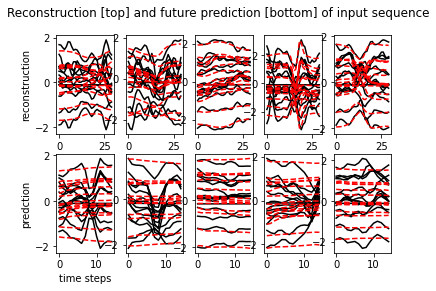

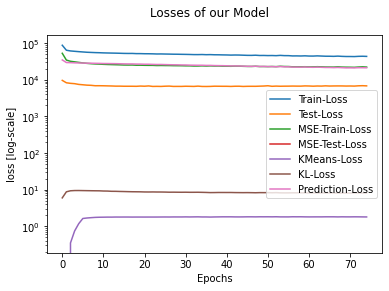

In [3]:
# Evaluate the network

vame.evaluate_model(config)

In [4]:
%%time
# Segment behavior

# vame.behavior_segmentation(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=[30])
vame.pose_segmentation(config)

Pose segmentation for VAME model: VAME 

Using CUDA
GPU active: True
GPU used: GeForce RTX 2080 Ti
Load model... 


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.42it/s]

Embedd latent vector for file 08_06_2020_18_24_41_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 04_06_2021_10_05_46_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:27, 23.34it/s]

Embedd latent vector for file 04_21_2021_15_50_50_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 03_06_2020_16_00_37_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 08_21_2020_16_24_35_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.09it/s]

Embedd latent vector for file 03_05_2020_15_39_38_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 09_07_2020_15_23_07_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.38it/s]

Embedd latent vector for file 09_07_2020_15_41_46_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.65it/s]

Embedd latent vector for file 08_12_2020_15_56_49_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 06_03_2021_11_01_42_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.06it/s]

Embedd latent vector for file 09_05_2020_16_16_21_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 08_08_2020_15_44_28_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 08_07_2020_16_39_29_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.11it/s]

Embedd latent vector for file 05_11_2021_09_57_59_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.04it/s]

Embedd latent vector for file 08_12_2020_15_29_25_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 27.82it/s]

Embedd latent vector for file 08_06_2020_18_46_29_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.65it/s]

Embedd latent vector for file 11_26_2019_16_39_57_miniscope_MM_191107_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 06_10_2021_11_05_21_miniscope_DG_210323_b_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 05_10_2021_10_59_09_miniscope_DG_210323_b_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.18it/s]

Embedd latent vector for file 12_12_2019_15_08_15_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 05_03_2021_09_35_13_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.61it/s]

Embedd latent vector for file 05_06_2021_10_19_02_miniscope_DG_210323_b_fail_nonres


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.52it/s]

Embedd latent vector for file 08_13_2020_15_36_29_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.15it/s]

Embedd latent vector for file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.29it/s]

Embedd latent vector for file 11_12_2019_16_54_56_miniscope_DG_190806_a_succ_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 04_13_2021_09_35_19_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.82it/s]

Embedd latent vector for file 11_11_2019_22_56_57_miniscope_DG_190806_a_succ_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 08_04_2020_15_49_56_miniscope_DG_200617_b_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 08_18_2020_16_34_54_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.46it/s]

Embedd latent vector for file 08_09_2020_15_08_18_miniscope_DG_200701_a_fail_alive


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.67it/s]

Embedd latent vector for file 08_17_2020_15_40_54_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.42it/s]

Embedd latent vector for file 11_26_2019_16_48_28_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.08it/s]

Embedd latent vector for file 09_03_2020_16_31_10_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 08_31_2020_16_17_53_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.11it/s]

Embedd latent vector for file 06_01_2021_09_51_27_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 04_02_2021_10_06_47_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 09_01_2020_16_55_25_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.56it/s]

Embedd latent vector for file 12_10_2019_16_57_26_miniscope_MM_191107_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.23it/s]

Embedd latent vector for file 09_04_2020_17_03_57_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 04_22_2021_09_44_38_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.42it/s]

Embedd latent vector for file 04_16_2021_08_57_45_miniscope_DG_210202_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.57it/s]

Embedd latent vector for file 06_18_2021_13_43_26_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.33it/s]

Embedd latent vector for file 04_26_2021_10_23_35_miniscope_DG_210323_b_habi_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 08_30_2020_16_35_54_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.60it/s]

Embedd latent vector for file 12_09_2019_16_49_50_miniscope_MM_191106_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 11_13_2019_18_14_36_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.16it/s]

Embedd latent vector for file 09_03_2020_16_47_03_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.54it/s]

Embedd latent vector for file 03_29_2021_09_25_44_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 08_13_2020_15_49_59_miniscope_DG_200701_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.66it/s]

Embedd latent vector for file 03_30_2021_09_51_19_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.23it/s]

Embedd latent vector for file 12_07_2019_15_20_56_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 04_27_2021_09_40_11_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.07it/s]

Embedd latent vector for file 09_01_2020_16_34_42_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.66it/s]

Embedd latent vector for file 06_18_2021_13_39_05_miniscope_DG_210323_b_succ_dark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 09_03_2020_16_21_39_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 08_03_2020_16_13_29_miniscope_DG_200701_a_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 08_31_2020_15_46_43_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 05_24_2021_11_23_26_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.52it/s]

Embedd latent vector for file 05_10_2021_10_45_08_miniscope_DG_210323_b_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.29it/s]

Embedd latent vector for file 12_04_2019_16_27_21_miniscope_MM_191108_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 08_14_2020_15_02_32_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.97it/s]

Embedd latent vector for file 11_26_2019_16_26_36_miniscope_MM_191107_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:23, 26.87it/s]

Embedd latent vector for file 09_07_2020_14_48_19_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 12_06_2019_14_07_11_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 11_13_2019_18_25_56_miniscope_DG_190810_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.68it/s]

Embedd latent vector for file 03_04_2020_16_12_03_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.38it/s]

Embedd latent vector for file 09_08_2020_15_16_25_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 03_17_2021_09_35_32_miniscope_DG_210202_a_habi_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 06_18_2021_13_58_30_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.49it/s]

Embedd latent vector for file 09_01_2020_16_39_52_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 05_07_2021_09_42_55_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.35it/s]

Embedd latent vector for file 11_11_2019_23_30_06_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.62it/s]

Embedd latent vector for file 05_25_2021_10_07_34_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.59it/s]

Embedd latent vector for file 09_05_2020_15_47_48_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.33it/s]

Embedd latent vector for file 12_07_2019_15_29_41_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.64it/s]

Embedd latent vector for file 08_31_2020_15_50_06_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 05_05_2021_09_33_14_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.79it/s]

Embedd latent vector for file 06_07_2021_09_58_06_miniscope_DG_210323_b_succ_head_distracted


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.11it/s]

Embedd latent vector for file 08_31_2020_16_29_59_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.73it/s]

Embedd latent vector for file 04_26_2021_09_25_07_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.35it/s]

Embedd latent vector for file 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 08_14_2020_15_44_42_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:23, 26.71it/s]

Embedd latent vector for file 08_14_2020_15_17_30_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.79it/s]

Embedd latent vector for file 04_22_2021_09_13_20_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 08_14_2020_15_54_58_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:25, 25.29it/s]

Embedd latent vector for file 09_03_2020_16_40_53_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.34it/s]

Embedd latent vector for file 04_12_2021_09_42_45_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.70it/s]

Embedd latent vector for file 08_20_2020_15_57_27_miniscope_DG_200701_a_succ_grabbedcable


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.30it/s]

Embedd latent vector for file 04_29_2021_10_10_04_miniscope_DG_210323_b_habi_badfluo_long


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.90it/s]

Embedd latent vector for file 06_02_2021_09_48_32_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 08_06_2020_18_30_31_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 08_18_2020_16_23_10_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.76it/s]

Embedd latent vector for file 09_03_2020_16_03_07_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 04_28_2021_09_24_14_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 08_14_2020_15_23_43_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.49it/s]

Embedd latent vector for file 09_05_2020_16_26_47_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.11it/s]

Embedd latent vector for file 04_23_2021_07_18_00_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.00it/s]

Embedd latent vector for file 07_31_2020_16_29_30_miniscope_DG_200701_a_habi_nocricket_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 03_06_2020_16_30_52_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 06_09_2021_09_49_26_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.82it/s]

Embedd latent vector for file 08_19_2020_16_52_39_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.77it/s]

Embedd latent vector for file 08_16_2020_15_50_17_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.64it/s]

Embedd latent vector for file 08_10_2020_16_48_58_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.82it/s]

Embedd latent vector for file 05_12_2021_10_01_30_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.52it/s]

Embedd latent vector for file 03_11_2020_16_14_11_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.09it/s]

Embedd latent vector for file 08_20_2020_16_13_59_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 03_12_2020_16_44_47_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:24, 25.62it/s]

Embedd latent vector for file 08_15_2020_16_28_36_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.31it/s]

Embedd latent vector for file 03_06_2020_16_17_02_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 08_05_2020_15_43_21_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.70it/s]

Embedd latent vector for file 05_03_2021_10_56_17_miniscope_DG_210323_b_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.58it/s]

Embedd latent vector for file 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.79it/s]

Embedd latent vector for file 09_02_2020_16_53_10_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 08_11_2020_15_44_45_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.85it/s]

Embedd latent vector for file 06_11_2021_10_31_45_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.90it/s]

Embedd latent vector for file 05_27_2021_09_47_19_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.57it/s]

Embedd latent vector for file 08_16_2020_16_13_04_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.86it/s]

Embedd latent vector for file 04_22_2021_09_18_21_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.37it/s]

Embedd latent vector for file 12_16_2019_16_21_34_miniscope_MM_191108_a_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.57it/s]

Embedd latent vector for file 04_12_2021_09_40_55_miniscope_DG_210202_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.43it/s]

Embedd latent vector for file 11_14_2019_17_46_42_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.08it/s]

Embedd latent vector for file 12_12_2019_15_16_04_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.35it/s]

Embedd latent vector for file 12_04_2019_15_45_59_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 04_27_2021_10_25_13_miniscope_DG_210323_b_habi_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.05it/s]

Embedd latent vector for file 08_30_2020_15_53_35_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 08_21_2020_15_32_26_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 05_06_2021_09_48_27_miniscope_DG_210202_a_succ_head_cable


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 08_10_2020_17_33_00_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.19it/s]

Embedd latent vector for file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 05_06_2021_10_39_13_miniscope_DG_210323_b_fail_nonres_injured_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.86it/s]

Embedd latent vector for file 08_16_2020_16_15_42_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.34it/s]

Embedd latent vector for file 08_14_2020_15_37_49_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 12_03_2019_15_31_21_miniscope_MM_191106_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.10it/s]

Embedd latent vector for file 08_18_2020_16_41_33_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 06_16_2021_10_05_57_miniscope_DG_210323_b_succ_dark_nofluo_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.88it/s]

Embedd latent vector for file 04_05_2021_10_25_10_miniscope_DG_210202_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.37it/s]

Embedd latent vector for file 03_02_2020_15_59_15_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.31it/s]

Embedd latent vector for file 08_08_2020_15_27_33_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.30it/s]

Embedd latent vector for file 08_14_2020_15_04_44_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.33it/s]

Embedd latent vector for file 06_01_2021_09_40_53_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 09_04_2020_16_30_05_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.82it/s]

Embedd latent vector for file 05_04_2021_09_48_58_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.34it/s]

Embedd latent vector for file 06_11_2021_09_48_42_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 09_01_2020_16_20_52_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 24.21it/s]

Embedd latent vector for file 04_23_2021_07_07_28_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 08_05_2020_15_36_29_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.46it/s]

Embedd latent vector for file 08_10_2020_17_20_19_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.02it/s]

Embedd latent vector for file 04_15_2021_10_22_42_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.24it/s]

Embedd latent vector for file 08_12_2020_16_21_45_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 12_02_2019_17_52_21_miniscope_MM_191108_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.83it/s]

Embedd latent vector for file 03_25_2021_09_45_37_miniscope_DG_210202_a_fail_nonres_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.15it/s]

Embedd latent vector for file 07_31_2020_16_44_36_miniscope_DG_200617_b_habi_nocricket_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.24it/s]

Embedd latent vector for file 06_10_2021_10_40_49_miniscope_DG_210323_b_succ_dark_head_baddark


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.38it/s]

Embedd latent vector for file 04_12_2021_09_50_24_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.35it/s]

Embedd latent vector for file 06_15_2021_09_56_55_miniscope_DG_210323_b_succ_dark_nofluo_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.93it/s]

Embedd latent vector for file 05_17_2021_09_20_56_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 03_22_2021_09_42_53_miniscope_DG_210202_a_habi


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:23, 26.67it/s]

Embedd latent vector for file 11_11_2019_22_43_04_miniscope_DG_190806_a_fail_nofluo


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.08it/s]

Embedd latent vector for file 03_10_2020_16_00_39_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.33it/s]

Embedd latent vector for file 09_04_2020_17_07_37_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 04_26_2021_09_49_24_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.68it/s]

Embedd latent vector for file 08_15_2020_15_58_47_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.40it/s]

Embedd latent vector for file 03_02_2020_16_29_48_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.57it/s]

Embedd latent vector for file 04_01_2021_09_51_46_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 08_14_2020_15_34_20_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.78it/s]

Embedd latent vector for file 04_30_2021_09_52_53_miniscope_DG_210202_a_succ_head_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.64it/s]

Embedd latent vector for file 05_06_2021_09_24_55_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.37it/s]

Embedd latent vector for file 03_06_2020_15_49_03_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 11_29_2019_14_09_23_miniscope_MM_191105_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.08it/s]

Embedd latent vector for file 08_21_2020_16_03_54_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.37it/s]

Embedd latent vector for file 08_31_2020_16_39_00_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.58it/s]

Embedd latent vector for file 05_12_2021_10_15_57_miniscope_DG_210323_b_fail_attempts_long


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.06it/s]

Embedd latent vector for file 12_07_2019_15_11_16_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.53it/s]

Embedd latent vector for file 06_08_2021_09_39_17_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 12_10_2019_15_00_45_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 05_04_2021_09_26_54_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.46it/s]

Embedd latent vector for file 04_09_2021_07_09_17_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.88it/s]

Embedd latent vector for file 03_31_2021_09_45_11_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 08_10_2020_17_07_51_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 08_20_2020_16_40_35_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.58it/s]

Embedd latent vector for file 09_04_2020_17_14_08_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.12it/s]

Embedd latent vector for file 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.33it/s]

Embedd latent vector for file 05_25_2021_10_13_40_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.59it/s]

Embedd latent vector for file 08_04_2020_15_43_15_miniscope_DG_200617_b_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 08_15_2020_16_36_57_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.35it/s]

Embedd latent vector for file 09_04_2020_16_43_01_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.64it/s]

Embedd latent vector for file 12_10_2019_15_35_36_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.49it/s]

Embedd latent vector for file 03_13_2020_13_49_34_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.79it/s]

Embedd latent vector for file 06_04_2021_10_23_41_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.33it/s]

Embedd latent vector for file 04_08_2021_09_55_39_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.92it/s]

Embedd latent vector for file 08_21_2020_15_29_32_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.11it/s]

Embedd latent vector for file 03_22_2021_09_19_25_miniscope_DG_210202_a_habi_smallfluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.58it/s]

Embedd latent vector for file 08_17_2020_15_36_48_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.12it/s]

Embedd latent vector for file 11_12_2019_17_02_59_miniscope_DG_190810_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 04_16_2021_08_47_55_miniscope_DG_210202_a_succ_latestop


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.03it/s]

Embedd latent vector for file 08_12_2020_15_32_21_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 05_04_2021_09_37_07_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.49it/s]

Embedd latent vector for file 04_21_2021_15_53_55_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.14it/s]

Embedd latent vector for file 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.29it/s]

Embedd latent vector for file 04_27_2021_09_43_37_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 09_05_2020_15_40_48_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 08_21_2020_15_58_04_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.10it/s]

Embedd latent vector for file 08_04_2020_15_15_34_miniscope_DG_200701_a_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.24it/s]

Embedd latent vector for file 03_10_2020_15_56_24_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.11it/s]

Embedd latent vector for file 03_23_2021_07_15_34_miniscope_DG_210202_a_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.40it/s]

Embedd latent vector for file 08_30_2020_15_40_53_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 05_28_2021_10_02_39_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.10it/s]

Embedd latent vector for file 11_29_2019_14_36_52_miniscope_MM_191106_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.11it/s]

Embedd latent vector for file 06_03_2021_10_55_27_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.39it/s]

Embedd latent vector for file 03_31_2021_09_49_31_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.11it/s]

Embedd latent vector for file 12_09_2019_15_21_10_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.34it/s]

Embedd latent vector for file 09_01_2020_16_29_24_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 08_12_2020_15_51_54_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.85it/s]

Embedd latent vector for file 06_07_2021_09_42_58_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 03_18_2021_09_32_46_miniscope_DG_210202_a_habi_badfov


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.94it/s]

Embedd latent vector for file 03_13_2020_13_14_07_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 12_10_2019_15_43_20_miniscope_MM_191108_a_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 06_02_2021_09_37_00_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.57it/s]

Embedd latent vector for file 12_16_2019_16_27_17_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 08_04_2020_15_36_08_miniscope_DG_200617_b_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.34it/s]

Embedd latent vector for file 08_10_2020_16_44_58_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.15it/s]

Embedd latent vector for file 05_05_2021_09_45_34_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.74it/s]

Embedd latent vector for file 03_22_2021_09_26_19_miniscope_DG_210202_a_habi_smallfluo


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.03it/s]

Embedd latent vector for file 12_07_2019_15_43_37_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 05_04_2021_10_25_31_miniscope_DG_210323_b_fail_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.16it/s]

Embedd latent vector for file 08_05_2020_16_20_09_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.33it/s]

Embedd latent vector for file 03_31_2021_09_38_46_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.12it/s]

Embedd latent vector for file 12_11_2019_16_53_36_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.76it/s]

Embedd latent vector for file 08_29_2020_16_33_45_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.15it/s]

Embedd latent vector for file 12_07_2019_15_15_49_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 05_27_2021_10_00_48_miniscope_DG_210323_b_succ_head_noncon


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.32it/s]

Embedd latent vector for file 05_06_2021_09_41_21_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.58it/s]

Embedd latent vector for file 11_12_2019_17_14_20_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 08_19_2020_16_33_11_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.34it/s]

Embedd latent vector for file 05_05_2021_09_26_05_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 04_21_2021_15_38_42_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 03_12_2020_16_30_37_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.94it/s]

Embedd latent vector for file 04_15_2021_10_39_38_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.79it/s]

Embedd latent vector for file 06_10_2021_11_20_06_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 09_04_2020_17_11_33_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.83it/s]

Embedd latent vector for file 03_15_2021_10_50_53_miniscope_DG_210202_a_habi_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:25, 24.43it/s]

Embedd latent vector for file 08_07_2020_17_08_34_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.87it/s]

Embedd latent vector for file 08_08_2020_15_50_40_miniscope_DG_200701_a_succ_noncon


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.33it/s]

Embedd latent vector for file 03_30_2021_09_36_54_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 05_05_2021_10_20_30_miniscope_DG_210323_b_fail_nonres


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.69it/s]

Embedd latent vector for file 09_04_2020_16_39_31_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.36it/s]

Embedd latent vector for file 05_10_2021_10_31_08_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.66it/s]

Embedd latent vector for file 07_31_2020_16_51_20_miniscope_DG_200617_b_habi_nocricket_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.72it/s]

Embedd latent vector for file 08_09_2020_16_13_20_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 09_06_2020_15_38_32_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 08_19_2020_15_51_39_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.07it/s]

Embedd latent vector for file 09_05_2020_16_19_09_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.19it/s]

Embedd latent vector for file 04_27_2021_09_54_58_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.21it/s]

Embedd latent vector for file 08_06_2020_17_58_44_miniscope_DG_200701_a_succ


  1%|█▊                                                                                                                                                                                                   | 6/638 [00:00<00:21, 29.30it/s]

Embedd latent vector for file 08_09_2020_16_26_36_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.94it/s]

Embedd latent vector for file 08_06_2020_17_47_03_miniscope_DG_200701_a_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 03_16_2021_09_53_54_miniscope_DG_210202_a_habi_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 03_12_2020_16_56_04_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 03_31_2021_09_19_18_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.54it/s]

Embedd latent vector for file 08_03_2020_16_21_24_miniscope_DG_200701_a_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.20it/s]

Embedd latent vector for file 04_15_2021_10_26_27_miniscope_DG_210202_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.62it/s]

Embedd latent vector for file 08_13_2020_16_09_18_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.21it/s]

Embedd latent vector for file 06_14_2021_11_04_14_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 09_06_2020_15_28_50_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:27, 22.78it/s]

Embedd latent vector for file 06_03_2021_10_51_19_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.37it/s]

Embedd latent vector for file 12_09_2019_15_30_13_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.42it/s]

Embedd latent vector for file 03_05_2020_15_46_40_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.08it/s]

Embedd latent vector for file 04_06_2021_09_53_32_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 30.00it/s]

Embedd latent vector for file 05_25_2021_10_20_05_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 31.80it/s]

Embedd latent vector for file 03_24_2021_13_59_13_miniscope_DG_210202_a_fail_nonres_attempts


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.33it/s]

Embedd latent vector for file 11_29_2019_15_49_40_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.82it/s]

Embedd latent vector for file 08_15_2020_16_18_50_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 05_25_2021_10_00_11_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.86it/s]

Embedd latent vector for file 08_31_2020_16_42_25_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 08_07_2020_16_05_16_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.21it/s]

Embedd latent vector for file 04_09_2021_07_14_09_miniscope_DG_210202_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.73it/s]

Embedd latent vector for file 12_09_2019_15_04_06_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.68it/s]

Embedd latent vector for file 08_06_2020_18_35_22_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.70it/s]

Embedd latent vector for file 08_09_2020_16_08_16_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 04_22_2021_09_26_54_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.21it/s]

Embedd latent vector for file 09_04_2020_17_23_03_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 12_10_2019_15_15_08_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.93it/s]

Embedd latent vector for file 12_02_2019_16_05_42_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.51it/s]

Embedd latent vector for file 04_28_2021_09_41_07_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.24it/s]

Embedd latent vector for file 06_08_2021_09_36_23_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.35it/s]

Embedd latent vector for file 05_12_2021_10_23_43_miniscope_DG_210323_b_fail_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.90it/s]

Embedd latent vector for file 06_03_2021_11_17_32_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.21it/s]

Embedd latent vector for file 12_07_2019_15_06_28_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:27, 23.02it/s]

Embedd latent vector for file 04_14_2021_12_37_38_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.43it/s]

Embedd latent vector for file 08_08_2020_16_26_31_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.25it/s]

Embedd latent vector for file 11_13_2019_18_19_35_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 04_06_2021_09_40_26_miniscope_DG_210202_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.36it/s]

Embedd latent vector for file 08_07_2020_16_08_55_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.95it/s]

Embedd latent vector for file 05_05_2021_10_34_14_miniscope_DG_210323_b_fail_nonres_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.30it/s]

Embedd latent vector for file 04_13_2021_09_20_05_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.72it/s]

Embedd latent vector for file 04_27_2021_09_34_46_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 09_04_2020_17_17_48_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.17it/s]

Embedd latent vector for file 05_04_2021_09_14_43_miniscope_DG_210202_a_succ_head_nofluo


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.94it/s]

Embedd latent vector for file 04_30_2021_10_09_41_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.90it/s]

Embedd latent vector for file 05_31_2021_11_09_06_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.11it/s]

Embedd latent vector for file 04_26_2021_09_33_47_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:28, 22.67it/s]

Embedd latent vector for file 03_30_2021_09_21_05_miniscope_DG_210202_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.72it/s]

Embedd latent vector for file 03_16_2021_10_11_02_miniscope_DG_210202_a_habi_nofluo


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:23, 27.52it/s]

Embedd latent vector for file 09_08_2020_15_32_30_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 03_29_2021_09_17_07_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_05_2020_15_22_44_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.12it/s]

Embedd latent vector for file 08_18_2020_16_31_06_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 08_03_2020_16_05_59_miniscope_DG_200701_a_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 11_29_2019_14_57_47_miniscope_MM_191106_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 04_16_2021_08_53_00_miniscope_DG_210202_a_succ_droppedframes


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:28, 22.57it/s]

Embedd latent vector for file 08_03_2020_16_57_30_miniscope_DG_200617_b_habi_nocricket


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 12_12_2019_15_04_45_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.29it/s]

Embedd latent vector for file 08_15_2020_16_05_59_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 04_29_2021_07_26_10_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 05_17_2021_09_44_06_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.68it/s]

Embedd latent vector for file 08_10_2020_16_52_15_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.20it/s]

Embedd latent vector for file 09_02_2020_17_38_56_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 03_19_2021_07_17_14_miniscope_DG_210202_a_habi_badfluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.49it/s]

Embedd latent vector for file 03_24_2021_13_45_32_miniscope_DG_210202_a_fail_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 24.12it/s]

Embedd latent vector for file 08_06_2020_18_42_09_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.35it/s]

Embedd latent vector for file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.64it/s]

Embedd latent vector for file 08_20_2020_15_51_33_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 08_15_2020_16_22_29_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 12_16_2019_16_34_45_miniscope_MM_191108_a_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 12_11_2019_17_09_52_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 04_07_2021_10_11_16_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.71it/s]

Embedd latent vector for file 08_13_2020_15_45_14_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 05_28_2021_09_54_22_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.12it/s]

Embedd latent vector for file 04_07_2021_10_01_51_miniscope_DG_210202_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 09_03_2020_16_09_44_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.23it/s]

Embedd latent vector for file 08_16_2020_15_56_30_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.65it/s]

Embedd latent vector for file 08_17_2020_16_19_31_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.98it/s]

Embedd latent vector for file 08_12_2020_16_24_56_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.49it/s]

Embedd latent vector for file 08_10_2020_16_41_32_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.68it/s]

Embedd latent vector for file 11_13_2019_18_04_22_miniscope_DG_190806_a_succ_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.48it/s]

Embedd latent vector for file 09_08_2020_15_06_13_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.39it/s]

Embedd latent vector for file 12_10_2019_16_44_10_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 08_06_2020_18_53_34_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.34it/s]

Embedd latent vector for file 04_29_2021_07_49_17_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 08_16_2020_16_04_28_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 06_15_2021_09_41_18_miniscope_DG_210323_b_succ_low_baddark_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 08_11_2020_15_27_09_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 05_12_2021_09_36_18_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.94it/s]

Embedd latent vector for file 03_05_2020_15_59_48_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.99it/s]

Embedd latent vector for file 08_21_2020_15_39_23_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.97it/s]

Embedd latent vector for file 08_30_2020_15_50_51_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.46it/s]

Embedd latent vector for file 03_26_2021_08_38_53_miniscope_DG_210202_a_fail_nonres_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 06_08_2021_09_42_55_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.78it/s]

Embedd latent vector for file 09_06_2020_14_55_10_miniscope_DG_200701_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.66it/s]

Embedd latent vector for file 06_11_2021_09_51_19_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.96it/s]

Embedd latent vector for file 06_18_2021_13_35_52_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 08_13_2020_16_12_01_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:18, 33.40it/s]

Embedd latent vector for file 04_28_2021_09_38_10_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.92it/s]

Embedd latent vector for file 03_29_2021_09_49_44_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.43it/s]

Embedd latent vector for file 06_11_2021_10_12_57_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 12_16_2019_16_31_08_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.30it/s]

Embedd latent vector for file 08_21_2020_15_36_39_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.59it/s]

Embedd latent vector for file 04_23_2021_07_11_50_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 09_03_2020_15_59_43_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.19it/s]

Embedd latent vector for file 04_05_2021_10_22_15_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 08_18_2020_16_08_29_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.35it/s]

Embedd latent vector for file 08_01_2020_13_24_45_miniscope_DG_200701_a_habi_nocricket_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.40it/s]

Embedd latent vector for file 04_13_2021_09_25_19_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 03_31_2021_09_23_53_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.18it/s]

Embedd latent vector for file 06_11_2021_10_03_53_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.00it/s]

Embedd latent vector for file 11_25_2019_15_15_55_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.12it/s]

Embedd latent vector for file 04_23_2021_07_14_57_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.28it/s]

Embedd latent vector for file 07_31_2020_16_13_37_miniscope_DG_200701_a_habi_nocricket_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.16it/s]

Embedd latent vector for file 05_31_2021_10_52_53_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.43it/s]

Embedd latent vector for file 05_11_2021_10_04_53_miniscope_DG_210323_b_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.58it/s]

Embedd latent vector for file 12_02_2019_16_13_23_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.86it/s]

Embedd latent vector for file 05_27_2021_09_42_42_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.15it/s]

Embedd latent vector for file 11_25_2019_16_04_36_miniscope_MM_191107_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 04_15_2021_10_34_04_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.98it/s]

Embedd latent vector for file 03_10_2020_16_17_45_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.41it/s]

Embedd latent vector for file 08_05_2020_15_55_12_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.40it/s]

Embedd latent vector for file 08_12_2020_15_47_44_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.19it/s]

Embedd latent vector for file 07_31_2020_16_57_29_miniscope_DG_200617_b_habi_nocricket_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 12_04_2019_16_44_23_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.18it/s]

Embedd latent vector for file 08_30_2020_16_28_07_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.34it/s]

Embedd latent vector for file 05_11_2021_09_51_25_miniscope_DG_210323_b_fail_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.97it/s]

Embedd latent vector for file 04_12_2021_09_37_46_miniscope_DG_210202_a_succ_distracted


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.36it/s]

Embedd latent vector for file 04_29_2021_07_45_16_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.87it/s]

Embedd latent vector for file 09_01_2020_16_47_10_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 08_16_2020_16_27_15_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.79it/s]

Embedd latent vector for file 04_12_2021_09_27_00_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_16_2020_15_39_22_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.98it/s]

Embedd latent vector for file 05_10_2021_10_07_32_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.68it/s]

Embedd latent vector for file 08_21_2020_16_28_13_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_19_2020_16_35_29_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.14it/s]

Embedd latent vector for file 04_02_2021_10_21_22_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 04_07_2021_10_07_27_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 05_12_2021_09_46_26_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 09_08_2020_15_20_34_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 06_11_2021_10_28_40_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 08_13_2020_15_42_16_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.90it/s]

Embedd latent vector for file 08_21_2020_15_42_56_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.40it/s]

Embedd latent vector for file 12_11_2019_17_01_21_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.63it/s]

Embedd latent vector for file 06_07_2021_09_39_54_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.39it/s]

Embedd latent vector for file 04_12_2021_09_34_13_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.58it/s]

Embedd latent vector for file 03_13_2020_13_44_46_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 09_01_2020_16_17_14_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 04_09_2021_07_11_46_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 26.39it/s]

Embedd latent vector for file 03_31_2021_09_35_52_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.31it/s]

Embedd latent vector for file 12_09_2019_16_38_36_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.44it/s]

Embedd latent vector for file 08_11_2020_15_17_38_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.92it/s]

Embedd latent vector for file 08_10_2020_16_56_35_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.65it/s]

Embedd latent vector for file 12_12_2019_15_18_57_miniscope_MM_191108_a_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 05_11_2021_09_21_45_miniscope_DG_210323_b_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.76it/s]

Embedd latent vector for file 11_13_2019_18_00_39_miniscope_DG_190806_a_succ_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 04_30_2021_09_28_50_miniscope_DG_210323_b_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.68it/s]

Embedd latent vector for file 08_21_2020_16_12_47_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.40it/s]

Embedd latent vector for file 04_07_2021_10_15_35_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.78it/s]

Embedd latent vector for file 04_12_2021_09_46_36_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.41it/s]

Embedd latent vector for file 11_29_2019_15_08_11_miniscope_MM_191107_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.26it/s]

Embedd latent vector for file 12_02_2019_16_37_29_miniscope_MM_191106_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.14it/s]

Embedd latent vector for file 08_09_2020_15_05_48_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.69it/s]

Embedd latent vector for file 04_01_2021_09_35_49_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.72it/s]

Embedd latent vector for file 08_31_2020_16_26_28_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.13it/s]

Embedd latent vector for file 05_11_2021_09_36_24_miniscope_DG_210323_b_fail_jumps


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 11_29_2019_15_42_19_miniscope_MM_191108_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 06_11_2021_10_00_17_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 03_19_2021_07_24_15_miniscope_DG_210202_a_habi_badfluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.34it/s]

Embedd latent vector for file 06_04_2021_10_35_02_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.38it/s]

Embedd latent vector for file 08_09_2020_14_53_16_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.57it/s]

Embedd latent vector for file 03_04_2020_16_16_18_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.31it/s]

Embedd latent vector for file 08_07_2020_16_16_35_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.19it/s]

Embedd latent vector for file 08_17_2020_15_45_26_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 04_26_2021_09_37_04_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.39it/s]

Embedd latent vector for file 08_29_2020_16_50_48_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.24it/s]

Embedd latent vector for file 06_17_2021_10_56_02_miniscope_DG_210323_b_succ_dark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.10it/s]

Embedd latent vector for file 04_21_2021_15_25_58_miniscope_DG_210202_a_succ


  0%|▌                                                                                                                                                                                                    | 2/638 [00:00<00:34, 18.54it/s]

Embedd latent vector for file 05_04_2021_09_40_04_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 06_08_2021_09_56_57_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.06it/s]

Embedd latent vector for file 05_12_2021_09_52_47_miniscope_DG_210323_b_succ_head_hyperactive


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.71it/s]

Embedd latent vector for file 12_04_2019_15_19_29_miniscope_MM_191106_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.92it/s]

Embedd latent vector for file 09_03_2020_16_43_43_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.12it/s]

Embedd latent vector for file 12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.44it/s]

Embedd latent vector for file 05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.19it/s]

Embedd latent vector for file 03_02_2020_15_35_18_miniscope_MM_200129_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.69it/s]

Embedd latent vector for file 08_29_2020_16_17_59_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 08_11_2020_16_00_10_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.69it/s]

Embedd latent vector for file 04_30_2021_09_22_31_miniscope_DG_210323_b_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.06it/s]

Embedd latent vector for file 11_25_2019_15_22_31_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.58it/s]

Embedd latent vector for file 04_22_2021_09_40_43_miniscope_DG_210202_a_succ_headout


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.10it/s]

Embedd latent vector for file 03_15_2021_10_43_36_miniscope_DG_210202_a_habi_nomini


  0%|▌                                                                                                                                                                                                    | 2/638 [00:00<00:34, 18.60it/s]

Embedd latent vector for file 03_02_2020_16_09_51_miniscope_MM_200129_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 04_26_2021_10_16_35_miniscope_DG_210323_b_habi_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.69it/s]

Embedd latent vector for file 09_05_2020_15_50_02_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.46it/s]

Embedd latent vector for file 08_09_2020_16_01_33_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 11_29_2019_16_02_26_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 12_03_2019_15_15_55_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.13it/s]

Embedd latent vector for file 03_29_2021_09_43_54_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.60it/s]

Embedd latent vector for file 12_02_2019_17_08_58_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.93it/s]

Embedd latent vector for file 03_19_2021_07_30_40_miniscope_DG_210202_a_habi_badfluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.56it/s]

Embedd latent vector for file 08_11_2020_16_06_06_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.19it/s]

Embedd latent vector for file 08_21_2020_16_33_02_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.30it/s]

Embedd latent vector for file 09_07_2020_14_51_32_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.69it/s]

Embedd latent vector for file 09_04_2020_16_49_06_miniscope_DG_200701_a_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 27.71it/s]

Embedd latent vector for file 06_17_2021_10_42_40_miniscope_DG_210323_b_succ_dark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 12_03_2019_15_24_04_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.75it/s]

Embedd latent vector for file 11_12_2019_16_41_32_miniscope_DG_190806_a_succ_nofluobadtrigger


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.11it/s]

Embedd latent vector for file 08_19_2020_16_05_59_miniscope_DG_200701_a_succ_grabbedcable


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 06_10_2021_10_20_43_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 24.11it/s]

Embedd latent vector for file 09_01_2020_16_03_24_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.30it/s]

Embedd latent vector for file 11_29_2019_14_50_39_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.36it/s]

Embedd latent vector for file 08_18_2020_16_38_40_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 06_11_2021_09_53_44_miniscope_DG_210323_b_habi


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_12_2020_16_06_17_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.09it/s]

Embedd latent vector for file 09_04_2020_16_33_29_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.34it/s]

Embedd latent vector for file 12_06_2019_14_00_21_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.10it/s]

Embedd latent vector for file 05_04_2021_10_32_40_miniscope_DG_210323_b_fail_injured_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 11_26_2019_17_00_05_miniscope_MM_191108_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.13it/s]

Embedd latent vector for file 05_03_2021_09_50_13_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 12_09_2019_15_25_14_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.39it/s]

Embedd latent vector for file 04_28_2021_09_27_49_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.67it/s]

Embedd latent vector for file 09_01_2020_16_14_05_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:27, 23.41it/s]

Embedd latent vector for file 11_11_2019_23_43_13_miniscope_DG_190810_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 06_10_2021_11_23_29_miniscope_DG_210323_b_habi


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.97it/s]

Embedd latent vector for file 09_02_2020_17_13_08_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.31it/s]

Embedd latent vector for file 09_03_2020_16_24_34_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 28.97it/s]

Embedd latent vector for file 05_11_2021_09_14_25_miniscope_DG_210323_b_fail_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 06_16_2021_10_28_09_miniscope_DG_210323_b_succ_low_baddark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.63it/s]

Embedd latent vector for file 09_03_2020_16_28_25_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.09it/s]

Embedd latent vector for file 06_08_2021_09_59_52_miniscope_DG_210323_b_succ_head


  0%|▌                                                                                                                                                                                                    | 2/638 [00:00<00:32, 19.52it/s]

Embedd latent vector for file 11_25_2019_15_28_57_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.56it/s]

Embedd latent vector for file 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 08_11_2020_15_33_47_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 08_11_2020_15_56_40_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 04_26_2021_10_09_34_miniscope_DG_210323_b_habi_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.19it/s]

Embedd latent vector for file 06_03_2021_10_58_50_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.69it/s]

Embedd latent vector for file 05_07_2021_09_26_50_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.65it/s]

Embedd latent vector for file 08_20_2020_16_43_39_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 09_05_2020_15_45_35_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 08_12_2020_16_02_32_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.25it/s]

Embedd latent vector for file 12_09_2019_16_41_05_miniscope_MM_191105_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.65it/s]

Embedd latent vector for file 06_17_2021_10_59_21_miniscope_DG_210323_b_succ_dark_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.63it/s]

Embedd latent vector for file 04_14_2021_12_40_17_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.92it/s]

Embedd latent vector for file 08_09_2020_16_03_39_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.11it/s]

Embedd latent vector for file 08_29_2020_15_58_33_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.29it/s]

Embedd latent vector for file 04_05_2021_10_52_52_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 08_21_2020_15_48_23_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.51it/s]

Embedd latent vector for file 06_09_2021_09_45_47_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.09it/s]

Embedd latent vector for file 09_02_2020_17_32_19_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.65it/s]

Embedd latent vector for file 05_24_2021_10_39_54_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.30it/s]

Embedd latent vector for file 08_15_2020_16_34_53_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.91it/s]

Embedd latent vector for file 11_14_2019_17_30_44_miniscope_DG_190806_a_succ_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.61it/s]

Embedd latent vector for file 11_29_2019_14_16_30_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.66it/s]

Embedd latent vector for file 03_06_2020_16_20_40_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.47it/s]

Embedd latent vector for file 08_20_2020_16_31_59_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.60it/s]

Embedd latent vector for file 04_14_2021_12_46_52_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.09it/s]

Embedd latent vector for file 12_02_2019_17_33_47_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 08_13_2020_15_52_37_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 03_19_2021_07_37_05_miniscope_DG_210202_a_habi_badfluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.64it/s]

Embedd latent vector for file 09_04_2020_16_52_56_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.29it/s]

Embedd latent vector for file 04_02_2021_10_34_47_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.19it/s]

Embedd latent vector for file 06_17_2021_10_29_17_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.43it/s]

Embedd latent vector for file 04_29_2021_07_32_02_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.70it/s]

Embedd latent vector for file 08_08_2020_16_29_56_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.75it/s]

Embedd latent vector for file 05_10_2021_10_52_12_miniscope_DG_210323_b_fail_jumps


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.43it/s]

Embedd latent vector for file 04_21_2021_15_19_32_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.39it/s]

Embedd latent vector for file 11_29_2019_14_43_47_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.75it/s]

Embedd latent vector for file 04_09_2021_07_07_05_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 31.88it/s]

Embedd latent vector for file 09_03_2020_16_12_49_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.94it/s]

Embedd latent vector for file 04_16_2021_08_55_41_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 30.65it/s]

Embedd latent vector for file 12_04_2019_15_56_34_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.50it/s]

Embedd latent vector for file 11_29_2019_15_16_19_miniscope_MM_191107_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.19it/s]

Embedd latent vector for file 08_13_2020_16_05_09_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 12_07_2019_15_52_11_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 09_02_2020_17_24_54_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 11_26_2019_16_54_02_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 08_12_2020_16_30_56_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.46it/s]

Embedd latent vector for file 08_29_2020_16_08_29_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 09_07_2020_15_26_46_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.18it/s]

Embedd latent vector for file 05_28_2021_10_16_39_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.47it/s]

Embedd latent vector for file 05_17_2021_10_03_28_miniscope_DG_210323_b_succ_noncon


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.31it/s]

Embedd latent vector for file 06_04_2021_10_29_52_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.92it/s]

Embedd latent vector for file 03_04_2020_15_37_26_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.68it/s]

Embedd latent vector for file 03_10_2020_16_13_35_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.70it/s]

Embedd latent vector for file 04_14_2021_12_49_53_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.33it/s]

Embedd latent vector for file 08_10_2020_17_13_00_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.20it/s]

Embedd latent vector for file 03_02_2020_16_20_39_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.10it/s]

Embedd latent vector for file 04_22_2021_09_21_54_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 03_04_2020_16_18_47_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.70it/s]

Embedd latent vector for file 09_07_2020_15_35_51_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.09it/s]

Embedd latent vector for file 11_12_2019_17_07_21_miniscope_DG_190810_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.69it/s]

Embedd latent vector for file 06_11_2021_10_16_01_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 08_09_2020_15_51_40_miniscope_DG_200701_a_succ


  0%|▌                                                                                                                                                                                                    | 2/638 [00:00<00:32, 19.60it/s]

Embedd latent vector for file 09_04_2020_17_00_52_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 11_26_2019_17_06_44_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.95it/s]

Embedd latent vector for file 09_07_2020_14_59_11_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.41it/s]

Embedd latent vector for file 04_13_2021_09_31_33_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 31.89it/s]

Embedd latent vector for file 09_01_2020_15_56_27_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 03_11_2020_15_58_51_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.95it/s]

Embedd latent vector for file 09_07_2020_14_53_42_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.48it/s]

Embedd latent vector for file 04_01_2021_09_43_29_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 12_07_2019_16_29_31_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.25it/s]

Embedd latent vector for file 08_17_2020_16_12_24_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.13it/s]

Embedd latent vector for file 03_10_2020_15_48_48_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.24it/s]

Embedd latent vector for file 04_27_2021_10_18_52_miniscope_DG_210323_b_habi_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.62it/s]

Embedd latent vector for file 09_05_2020_16_12_58_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.72it/s]

Embedd latent vector for file 04_29_2021_07_29_23_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.69it/s]

Embedd latent vector for file 03_04_2020_15_46_47_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.60it/s]

Embedd latent vector for file 09_08_2020_15_23_32_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.44it/s]

Embedd latent vector for file 06_04_2021_10_19_58_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 05_17_2021_09_51_23_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.73it/s]

Embedd latent vector for file 12_03_2019_15_00_53_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.89it/s]

Embedd latent vector for file 06_14_2021_11_22_15_miniscope_DG_210323_b_succ_dark_nofluo_debris_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 05_07_2021_09_45_32_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.82it/s]

Embedd latent vector for file 06_02_2021_09_42_16_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:27, 23.39it/s]

Embedd latent vector for file 08_19_2020_16_44_52_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 09_02_2020_17_35_23_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.13it/s]

Embedd latent vector for file 08_09_2020_15_44_35_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 09_03_2020_16_06_54_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 12_07_2019_15_34_47_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.91it/s]

Embedd latent vector for file 05_06_2021_09_36_06_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.58it/s]

Embedd latent vector for file 08_29_2020_16_26_47_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 08_17_2020_15_43_31_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 12_02_2019_16_27_33_miniscope_MM_191105_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.89it/s]

Embedd latent vector for file 04_21_2021_15_15_12_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.84it/s]

Embedd latent vector for file 06_04_2021_10_16_56_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 05_07_2021_09_35_17_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.12it/s]

Embedd latent vector for file 05_24_2021_10_43_55_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.74it/s]

Embedd latent vector for file 06_10_2021_10_24_12_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.62it/s]

Embedd latent vector for file 12_06_2019_14_47_35_miniscope_MM_191106_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.39it/s]

Embedd latent vector for file 06_02_2021_09_50_52_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.64it/s]

Embedd latent vector for file 03_23_2021_07_36_47_miniscope_DG_210202_a_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.43it/s]

Embedd latent vector for file 06_14_2021_11_53_28_miniscope_DG_210323_b_succ_low_head_baddark


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 05_03_2021_09_22_13_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.21it/s]

Embedd latent vector for file 12_09_2019_16_53_42_miniscope_MM_191106_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 12_02_2019_17_44_49_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.26it/s]

Embedd latent vector for file 08_06_2020_17_54_57_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.57it/s]

Embedd latent vector for file 06_02_2021_09_45_43_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.98it/s]

Embedd latent vector for file 06_15_2021_09_37_13_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 09_06_2020_15_14_12_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.44it/s]

Embedd latent vector for file 08_07_2020_16_57_16_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.83it/s]

Embedd latent vector for file 08_10_2020_16_38_11_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.98it/s]

Embedd latent vector for file 05_24_2021_11_07_58_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 12_03_2019_16_42_00_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.35it/s]

Embedd latent vector for file 08_20_2020_16_36_12_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 05_07_2021_09_21_22_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 04_01_2021_09_55_30_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 12_12_2019_15_00_56_miniscope_MM_191108_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 08_29_2020_16_31_16_miniscope_DG_200617_b_succ_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.00it/s]

Embedd latent vector for file 09_08_2020_15_03_49_miniscope_DG_200701_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.38it/s]

Embedd latent vector for file 08_10_2020_16_31_43_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.80it/s]

Embedd latent vector for file 08_05_2020_16_06_18_miniscope_DG_200617_b_succ_earlystop


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.39it/s]

Embedd latent vector for file 04_23_2021_07_24_16_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.46it/s]

Embedd latent vector for file 05_17_2021_10_10_32_miniscope_DG_210323_b_succ_noncon


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.88it/s]

Embedd latent vector for file 06_04_2021_10_13_58_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 08_15_2020_15_41_21_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.81it/s]

Embedd latent vector for file 08_21_2020_16_18_56_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.99it/s]

Embedd latent vector for file 08_13_2020_15_59_37_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.34it/s]

Embedd latent vector for file 08_17_2020_16_01_03_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_08_2020_16_00_22_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 03_05_2020_15_32_18_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 11_26_2019_16_20_21_miniscope_MM_191107_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.11it/s]

Embedd latent vector for file 06_17_2021_10_39_40_miniscope_DG_210323_b_succ_dark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 06_07_2021_09_50_11_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 03_26_2021_08_53_20_miniscope_DG_210202_a_fail_nonres_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 05_06_2021_09_38_47_miniscope_DG_210202_a_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 04_23_2021_07_27_39_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:20, 31.68it/s]

Embedd latent vector for file 08_31_2020_16_22_19_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 09_08_2020_15_54_36_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.94it/s]

Embedd latent vector for file 11_25_2019_14_55_06_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.25it/s]

Embedd latent vector for file 08_31_2020_16_36_15_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 03_05_2020_16_13_46_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.34it/s]

Embedd latent vector for file 12_10_2019_15_05_17_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.94it/s]

Embedd latent vector for file 08_20_2020_16_27_00_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.34it/s]

Embedd latent vector for file 04_08_2021_09_51_05_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.79it/s]

Embedd latent vector for file 04_02_2021_10_03_36_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.30it/s]

Embedd latent vector for file 06_09_2021_10_06_13_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 04_27_2021_10_11_04_miniscope_DG_210323_b_habi_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.88it/s]

Embedd latent vector for file 03_05_2020_16_07_59_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 26.11it/s]

Embedd latent vector for file 08_18_2020_15_54_55_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 06_16_2021_10_16_26_miniscope_DG_210323_b_succ_low_baddark_tangled_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.57it/s]

Embedd latent vector for file 03_11_2020_16_47_49_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 06_01_2021_09_59_05_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 11_29_2019_15_56_39_miniscope_MM_191108_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.27it/s]

Embedd latent vector for file 05_31_2021_10_41_31_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 05_07_2021_10_42_18_miniscope_DG_210323_b_fail_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.89it/s]

Embedd latent vector for file 05_17_2021_09_38_56_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 05_17_2021_09_29_34_miniscope_DG_210323_b_fail


  0%|▌                                                                                                                                                                                                    | 2/638 [00:00<00:34, 18.54it/s]

Embedd latent vector for file 06_10_2021_11_00_30_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 06_18_2021_13_54_19_miniscope_DG_210323_b_succ_dark_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.79it/s]

Embedd latent vector for file 08_13_2020_16_26_36_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.67it/s]

Embedd latent vector for file 08_09_2020_14_55_56_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.50it/s]

Embedd latent vector for file 04_06_2021_09_44_21_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.68it/s]

Embedd latent vector for file 08_29_2020_16_46_00_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 08_10_2020_17_24_14_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.10it/s]

Embedd latent vector for file 08_12_2020_16_14_41_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.45it/s]

Embedd latent vector for file 04_08_2021_09_58_40_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.54it/s]

Embedd latent vector for file 05_06_2021_09_44_17_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.96it/s]

Embedd latent vector for file 06_04_2021_10_32_53_miniscope_DG_210323_b_succ_noncon


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 06_09_2021_09_59_30_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.45it/s]

Embedd latent vector for file 08_08_2020_16_15_39_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.58it/s]

Embedd latent vector for file 08_20_2020_15_54_48_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.95it/s]

Embedd latent vector for file 05_31_2021_10_47_54_miniscope_DG_210323_b_succ_head_injured


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 08_29_2020_16_38_23_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 05_04_2021_10_46_27_miniscope_DG_210323_b_fail_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.83it/s]

Embedd latent vector for file 05_25_2021_09_43_20_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.39it/s]

Embedd latent vector for file 04_28_2021_09_35_35_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.01it/s]

Embedd latent vector for file 04_02_2021_10_16_10_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.58it/s]

Embedd latent vector for file 12_12_2019_15_23_10_miniscope_MM_191108_a_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.50it/s]

Embedd latent vector for file 03_06_2020_16_04_24_miniscope_MM_200129_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.71it/s]

Embedd latent vector for file 06_08_2021_09_50_54_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 03_06_2020_16_25_04_miniscope_MM_200129_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.56it/s]

Embedd latent vector for file 04_30_2021_10_02_50_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.72it/s]

Embedd latent vector for file 03_02_2020_15_54_55_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.13it/s]

Embedd latent vector for file 04_16_2021_08_37_19_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.46it/s]

Embedd latent vector for file 06_10_2021_10_49_49_miniscope_DG_210323_b_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.94it/s]

Embedd latent vector for file 04_02_2021_10_10_35_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.82it/s]

Embedd latent vector for file 06_18_2021_13_50_35_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.09it/s]

Embedd latent vector for file 06_10_2021_10_44_39_miniscope_DG_210323_b_succ_dark_head_baddark_debris


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.52it/s]

Embedd latent vector for file 08_16_2020_16_09_31_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.71it/s]

Embedd latent vector for file 12_06_2019_15_18_15_miniscope_MM_191107_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.69it/s]

Embedd latent vector for file 05_28_2021_09_58_47_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.00it/s]

Embedd latent vector for file 08_09_2020_15_57_15_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 08_30_2020_15_47_33_miniscope_DG_200701_a_succ_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 05_10_2021_10_38_33_miniscope_DG_210323_b_fail_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.78it/s]

Embedd latent vector for file 08_06_2020_17_33_37_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.95it/s]

Embedd latent vector for file 08_29_2020_16_04_30_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 06_09_2021_09_52_02_miniscope_DG_210323_b_succ_head_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 03_15_2021_10_57_23_miniscope_DG_210202_a_habi_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.25it/s]

Embedd latent vector for file 08_09_2020_15_03_09_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.22it/s]

Embedd latent vector for file 09_02_2020_16_55_43_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.49it/s]

Embedd latent vector for file 03_30_2021_09_27_31_miniscope_DG_210202_a_succ_cutearly


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 04_15_2021_10_30_39_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.66it/s]

Embedd latent vector for file 04_27_2021_09_50_05_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.46it/s]

Embedd latent vector for file 03_23_2021_07_28_32_miniscope_DG_210202_a_habi


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 26.68it/s]

Embedd latent vector for file 04_07_2021_09_58_32_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.69it/s]

Embedd latent vector for file 09_06_2020_15_51_43_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 08_31_2020_15_59_34_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.04it/s]

Embedd latent vector for file 09_02_2020_17_17_37_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.94it/s]

Embedd latent vector for file 05_07_2021_10_22_29_miniscope_DG_210323_b_fail_nonres_injured


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 08_17_2020_16_10_15_miniscope_DG_200617_b_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.68it/s]

Embedd latent vector for file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.46it/s]

Embedd latent vector for file 03_04_2020_15_54_26_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 12_07_2019_16_23_23_miniscope_MM_191106_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.30it/s]

Embedd latent vector for file 11_26_2019_15_52_26_miniscope_MM_191106_a_fail_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 27.90it/s]

Embedd latent vector for file 12_02_2019_16_52_33_miniscope_MM_191106_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.99it/s]

Embedd latent vector for file 05_10_2021_10_14_34_miniscope_DG_210323_b_fail


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.95it/s]

Embedd latent vector for file 08_31_2020_15_54_51_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.82it/s]

Embedd latent vector for file 08_11_2020_16_10_57_miniscope_DG_200617_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 28.90it/s]

Embedd latent vector for file 08_16_2020_15_35_26_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.05it/s]

Embedd latent vector for file 09_01_2020_16_10_27_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 24.00it/s]

Embedd latent vector for file 08_08_2020_15_47_53_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 04_26_2021_09_52_36_miniscope_DG_210202_a_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.27it/s]

Embedd latent vector for file 05_31_2021_10_56_27_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.24it/s]

Embedd latent vector for file 04_29_2021_07_36_15_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 09_05_2020_15_59_18_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.48it/s]

Embedd latent vector for file 04_26_2021_09_30_05_miniscope_DG_210202_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.44it/s]

Embedd latent vector for file 12_04_2019_15_23_56_miniscope_MM_191106_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.05it/s]

Embedd latent vector for file 11_11_2019_22_48_32_miniscope_DG_190806_a_fail_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.89it/s]

Embedd latent vector for file 11_11_2019_01_21_58_miniscope_DG_190806_a_fail_nofluo


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 11_29_2019_14_03_19_miniscope_MM_191105_a_fail_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 24.05it/s]

Embedd latent vector for file 12_06_2019_14_15_39_miniscope_MM_191105_a_succ_nomini


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.42it/s]

Embedd latent vector for file 06_16_2021_10_01_37_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.00it/s]

Embedd latent vector for file 05_24_2021_11_01_01_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:24, 25.86it/s]

Embedd latent vector for file 06_09_2021_10_09_26_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.11it/s]

Embedd latent vector for file 03_24_2021_13_38_36_miniscope_DG_210202_a_fail_nonres


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.48it/s]

Embedd latent vector for file 05_07_2021_10_29_07_miniscope_DG_210323_b_fail_nonres_injured_attempts


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.23it/s]

Embedd latent vector for file 05_10_2021_10_23_14_miniscope_DG_210323_b_fail


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.39it/s]

Embedd latent vector for file 05_05_2021_09_29_50_miniscope_DG_210202_a_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 25.27it/s]

Embedd latent vector for file 03_13_2020_13_53_47_miniscope_MM_200129_b_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 32.99it/s]

Embedd latent vector for file 04_12_2021_09_31_13_miniscope_DG_210202_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.21it/s]

Embedd latent vector for file 06_04_2021_10_26_21_miniscope_DG_210323_b_succ_head


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:21, 29.32it/s]

Embedd latent vector for file 08_16_2020_15_43_35_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:25, 24.90it/s]

Embedd latent vector for file 08_06_2020_17_41_32_miniscope_DG_200701_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.36it/s]

Embedd latent vector for file 03_11_2020_16_10_08_miniscope_MM_200129_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.41it/s]

Embedd latent vector for file 12_04_2019_15_52_05_miniscope_MM_191107_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:26, 23.61it/s]

Embedd latent vector for file 05_28_2021_10_12_56_miniscope_DG_210323_b_succ_head


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:21, 29.71it/s]

Embedd latent vector for file 12_10_2019_16_36_38_miniscope_MM_191106_a_succ_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:23, 27.04it/s]

Embedd latent vector for file 08_04_2020_15_08_43_miniscope_DG_200701_a_habi_nocricket


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.96it/s]

Embedd latent vector for file 09_03_2020_16_15_16_miniscope_DG_200701_a_succ


  1%|█▏                                                                                                                                                                                                   | 4/638 [00:00<00:19, 33.00it/s]

Embedd latent vector for file 08_01_2020_13_53_40_miniscope_DG_200617_b_habi_nocricket_nomini


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 28.77it/s]

Embedd latent vector for file 12_11_2019_17_05_25_miniscope_MM_191108_a_succ


  0%|▉                                                                                                                                                                                                    | 3/638 [00:00<00:22, 27.97it/s]

Embedd latent vector for file 08_17_2020_15_34_07_miniscope_DG_200701_a_succ_injured


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [00:23<00:00, 27.39it/s]


For all animals the same k-Means parameterization of latent vectors is applied for 15 cluster
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_06_2020_18_24_41_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_06_2021_10_05_46_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_21_2021_15_50_50_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_06_2020_16_00_37_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_21_2020_16_24_35_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_05_2020_15_39_38_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_07_2020_15_23_07_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_07_202

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\07_31_2020_16_29_30_miniscope_DG_200701_a_habi_nocricket_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_06_2020_16_30_52_miniscope_MM_200129_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_09_2021_09_49_26_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_19_2020_16_52_39_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_16_2020_15_50_17_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_10_2020_16_48_58_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_12_2021_10_01_30_miniscope_DG_210323_b_succ_head_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_11_2020_16_14_11_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VA

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_05_2020_15_40_48_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_21_2020_15_58_04_miniscope_DG_200617_b_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_04_2020_15_15_34_miniscope_DG_200701_a_habi_nocricket\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_10_2020_15_56_24_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_23_2021_07_15_34_miniscope_DG_210202_a_habi\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_30_2020_15_40_53_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_28_2021_10_02_39_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\11_29_2019_14_36_52_miniscope_MM_191106_a_fail_nomini\VAME\kmeans-15\
D:

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_13_2020_15_45_14_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_28_2021_09_54_22_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_07_2021_10_01_51_miniscope_DG_210202_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_03_2020_16_09_44_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_16_2020_15_56_30_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_17_2020_16_19_31_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_12_2020_16_24_56_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_10_2020_16_41_32_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VA

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_21_2021_15_25_58_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_04_2021_09_40_04_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_08_2021_09_56_57_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_12_2021_09_52_47_miniscope_DG_210323_b_succ_head_hyperactive\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\12_04_2019_15_19_29_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_03_2020_16_43_43_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\12_04_2019_15_29_28_miniscope_MM_191106_a_succ_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\05_03_2021_09_47_18_miniscope_DG_210202_a_succ_head\VAME\kmean

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_11_2021_10_16_01_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_09_2020_15_51_40_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_04_2020_17_00_52_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\11_26_2019_17_06_44_miniscope_MM_191108_a_fail_nomini\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_07_2020_14_59_11_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_13_2021_09_31_33_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\09_01_2020_15_56_27_miniscope_DG_200701_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_21_2020_15_34_25_miniscope_DG_200701_a_succ_injured\VAME\kmeans-15\
D:\VAME_projects\VAM

D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_30_2021_10_02_50_miniscope_DG_210202_a_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\03_02_2020_15_54_55_miniscope_MM_200129_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_16_2021_08_37_19_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_10_2021_10_49_49_miniscope_DG_210323_b_habi\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\04_02_2021_10_10_35_miniscope_DG_210202_a_succ\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_18_2021_13_50_35_miniscope_DG_210323_b_succ_head\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\06_10_2021_10_44_39_miniscope_DG_210323_b_succ_dark_head_baddark_debris\VAME\kmeans-15\
D:\VAME_projects\VAME_prey_mouse15dim-Oct25-2021\results\08_16_2020_16_09_31_miniscope_DG_200617_b_succ\VAME\kmeans-15\
D:\VA

In [ ]:
# Visualize embedding
# vame.visualization(config, label=None)

In [ ]:
# Create motif videos
# vame.motif_videos(config, videoType='.avi')

In [ ]:
# Community analysis

# vame.community(config, show_umap=False, cut_tree=None)

In [ ]:
# Quantify behavior

# vame.behavior_quantification(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=30)